In [2]:
import os
import numpy as np
import gensim
import pandas as pd
import seaborn as sns
import ast
import re
import operator
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from neurotools.language.simple_tokenizer import SimpleTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
%matplotlib inline

# Other Brands

In this notebook, we consolidate the functions defined in the last notebooks and apply the same analysis done in volkswagen-3 for the other car brands.

In [2]:
# get list of all csv files for other car brands stored in separated_pl
files = ['separated_pl/' + x for x in os.listdir('separated_pl') if x.endswith('.csv')]
filenames = [x[x.find('/')+1: x.find('.csv')] for x in files]

In [2]:
emb = gensim.models.KeyedVectors.load_word2vec_format('data/pl_pl_commoncrawl_v3.bin', binary=True, encoding='utf-8', unicode_errors='ignore')

In [3]:
tokenizer = SimpleTokenizer('pl') 

Extra characters read for pl
Stopwords set read for pl
Lemma lookup read for pl


# Function Definitions

In [4]:
def get_average_vector(words, emb):
    """
        Average the word vectors of a list of words.
    """
    words_in_emb = [emb[word] for word in words if word in emb.vocab.keys() and word != 'pistolet']
    total = np.sum(words_in_emb, axis=0)
    count = len(words_in_emb)
    return total / count

In [5]:
def get_weighted_average_vector(words, word_to_idf, emb, top_x = None):
    """
        Average the word vectors of a list of words.
    """
    # only consider words IN embedding model and in TFIDF vectorizer
    words = [word for word in words if word in word_to_idf.keys() and word in emb.vocab.keys()]
    if top_x != None:
        ranked_words = [word for word in sorted(words, key=lambda x: -word_to_idf[x])]
        # sometimes words at the boundary are equal to words below boundary: include these words
        words = [word for word in ranked_words if word_to_idf[word] >= word_to_idf[ranked_words[round(top_x*len(words))-1]]] 
    weighted = [word_to_idf[word] * emb[word] for word in words]
    total = np.sum(weighted, axis=0)
    count = len(weighted)
    return total / count

In [6]:
def fix_labels(x):
    if not pd.isnull(x['en_label']):
        label = x['en_label']
    else:
        label = x['de_label']#re.sub(r'[^a-z]', '', x['en'].split()[0].lower()) + '_nan'
    return label

In [7]:
def preprocess_dimensions():
    dimensions = pd.read_csv('data/dimensions.csv')[['en_label', 'de_label', 'pl', 'en']]
    dimensions = dimensions[~dimensions['pl'].isnull()].reset_index().drop(columns='index')
    dimensions['pl_no_nie'] = dimensions['pl'].map(lambda words: tokenizer.tokenize(' '.join([word for word in words.split() if not word.startswith('nie')])))
    dimensions['dimension'] = dimensions['pl_no_nie'].map(lambda x: get_average_vector(x, emb))
    dimensions['label'] = dimensions.apply(fix_labels, axis=1)
    return dimensions

In [8]:
def cosine_similarity(a,b):
    """
        Compute the cosine similarity of a and b.
    """
    return np.dot(a,b) / ( (np.dot(a,a) **.5) * (np.dot(b,b) ** .5) )

In [9]:
def get_similarity_with_dimensions(row, dimensions):
    """
        Get similarity of row's word vector and every dimension.
        row : row of the movie dataframe
        dimensions : dataframe containing Neuroflash dimensions
    """
    for k in range(dimensions['dimension'].shape[0]):
        name = 'dim_' + str(k) + '_' + str(dimensions['label'].iloc[k])
        # define a new column for the cosine similarity of dimension k and the post text
        row[name] = cosine_similarity(row['wv'], dimensions['dimension'].iloc[k])
    return row

In [10]:
def preprocess_dimensions():
    dimensions = pd.read_csv('data/dimensions.csv')[['en_label', 'de_label', 'pl', 'en']]
    dimensions = dimensions[~dimensions['pl'].isnull()].reset_index().drop(columns='index')
    dimensions['pl_no_nie'] = dimensions['pl'].map(lambda words: tokenizer.tokenize(' '.join([word for word in words.split() if not word.startswith('nie')])))
    dimensions['dimension'] = dimensions['pl_no_nie'].map(lambda x: get_average_vector(x, emb))
    dimensions['label'] = dimensions.apply(fix_labels, axis=1)
    return dimensions

In [11]:
def preprocess_csv(csv_file, with_nie = False):
    """
        Preprocess Facebook data to return only text and success metric. Optional flag if whether to include
        words with nie or not
    """
    pl = pd.read_csv(csv_file, encoding='cp1250')
    pl = pl.groupby('Post_text').head(1).reset_index().drop(columns = 'index')
    pl['Actual'] = pl['Post_text']
    pl = pl[~pl["Post_text"].isnull()].reset_index()
    if not with_nie:
        pl['Post_text'] = pl['Post_text'].str.lower().str.split().map(lambda x: tokenizer.tokenize(' '.join([word for word in x if not word.startswith('nie')])))
    pl['success'] = (1/8) * pl['Total_likes'] + pl['Total_comments'] + pl['Shares_count']
    pl = pl[['Actual', 'Post_text', 'success']]
    #pl = pl[['Post_text', 'success']]
    return pl

In [12]:
def get_idf_map(pl):
    tfidf = TfidfVectorizer(use_idf=True)
    pl['Post_text_string'] = pl['Post_text'].map(lambda x: ' '.join(x))
    tfidf.fit_transform(pl['Post_text_string'])
    word_to_idf = dict((x[0], tfidf.idf_[x[1]]) for x in sorted(tfidf.vocabulary_.items(), key=operator.itemgetter(1)))
    return word_to_idf

In [13]:
def get_similarity_features(pl, emb, dimensions, label, top_x = None):
    if top_x != None:
        top_string = '30'
    else:
        top_string = ''
    word_to_idf = get_idf_map(pl)
    pl['wv'] = pl['Post_text'].map(lambda x: get_weighted_average_vector(x, word_to_idf, emb, top_x))
    pl = pl.apply(lambda x: get_similarity_with_dimensions(x, dimensions), axis=1)
    pl = pl.convert_objects(convert_numeric=True)
    pl.to_csv('data/brands/idf{0}/no_nie_{0}tfidf_{1}.csv'.format(top_string, label), index=False)
    return pl

In [1]:
def get_label(string):
    """
        Convert feature names to 'more X association' labels
    """
#     return 'more {} associations'.format(string[5+string[4:].find('_'):])
    if string != 'success':
        return string[6 + string[5:].find('_'):]
    else:
        return string

In [15]:
def get_top_bot(pl, label, top_string = ''):
    """
        Get the top 10 positive and negative correlations and plot these in bar charts.
        Also return a csv file of the pairwise correlations of the associations and 
        success metric.
    """
    corr_matrix = pl.corr()
    corr_success = corr_matrix['success']
    corr_success = corr_success[~pd.isnull(corr_success)].sort_values(ascending=False)
    upper = list(corr_success.iloc[1:11].index)
    lower = list(corr_success.iloc[-10:].index)
    dims_to_graph = upper + lower
    to_bar = corr_success.loc[dims_to_graph].sort_values(ascending=True)
    
    plt.figure(figsize=(16,8))
    plt.barh(range(len(to_bar.index))[:10], to_bar.values[:10], color='lightcoral')
    plt.title(label, size = 20)
    plt.yticks(range(len(to_bar.index))[:10], [get_label(x) for x in np.array(to_bar.index)[:10]], size=15);
    plt.xticks(size=15);
    plt.xlabel('Correlation with Success', size=20)
    plt.savefig('./fig/brands/idf{}/bot_{}_10.png'.format(top_string, label), bbox_inches='tight');
    
    plt.figure(figsize=(16,8))
    plt.barh(range(len(to_bar.index))[10:], to_bar.values[10:], color='limegreen')
    plt.title(label, size = 20)
    plt.yticks(range(len(to_bar.index))[10:], [get_label(x) for x in np.array(to_bar.index)[10:]], size=15);
    plt.xticks(size=15);
    plt.xlabel('Correlation with Success', size=20)
    plt.savefig('./fig/brands/idf{}/top_{}_10.png'.format(top_string, label), bbox_inches='tight');
    
    corr_matrix.to_csv('data/brands/idf{}/unlabeled_all_correlogram_{}.csv'.format(top_string, label))

    matrix_cols = ['success'] + dims_to_graph
    correlogram = corr_matrix.loc[matrix_cols, matrix_cols]
    correlogram.index = [get_label(re.sub(r'_[0-9]+', '', x)) for x in correlogram.index]
    correlogram.columns = [get_label(re.sub(r'_[0-9]+', '', x)) for x in correlogram.columns]
    correlogram.to_csv('data/brands/idf{}/correlogram_{}.csv'.format(top_string, label))
    
    plt.figure(figsize=(16,12))
    sns.heatmap(correlogram)
    plt.title(label, size = 20)
    plt.xticks(size=15, rotation = 90);
    plt.yticks(size=15, rotation = 0);
    plt.savefig('fig/brands/idf{}/correlogram_{}.png'.format(top_string, label), bbox_inches='tight');

# Run analysis on other files

In [16]:
dimensions = preprocess_dimensions()

doing hondapolska


/Users/piocalderon/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/Users/piocalderon/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in multiply
  # This is added back by InteractiveShellApp.init_path()
/Users/piocalderon/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/Users/piocalderon/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':


doing chevroletpl
doing bmw.polska


/Users/piocalderon/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/Users/piocalderon/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in multiply
  # This is added back by InteractiveShellApp.init_path()


doing seatpolska
doing skodapolska
doing fiatpl
doing ford.polska


/Users/piocalderon/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


doing kiamotorspolska
doing mercedesbenzpolska
doing lexuspolska
doing landroverpolska
doing jaguarpolska
doing toyotapolska
doing ferrarikatowice
doing chryslerpolska
error encountered in chryslerpolska
doing audipl
doing porschepl
doing citroenpolska
doing volkswagenpolska
doing peugeotpolska
doing renaultpolska
doing hyundaipolska
doing jeeppl
doing opelklub


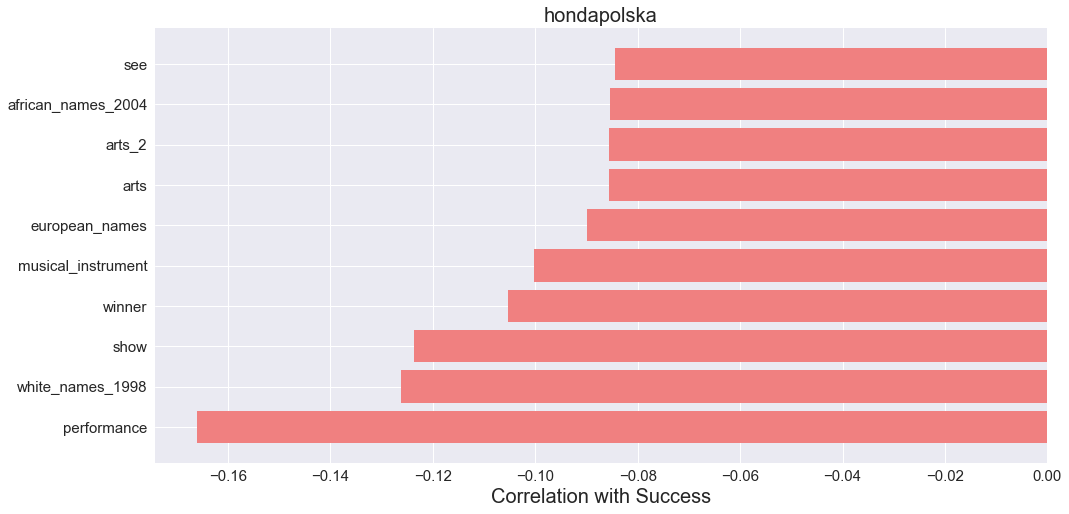

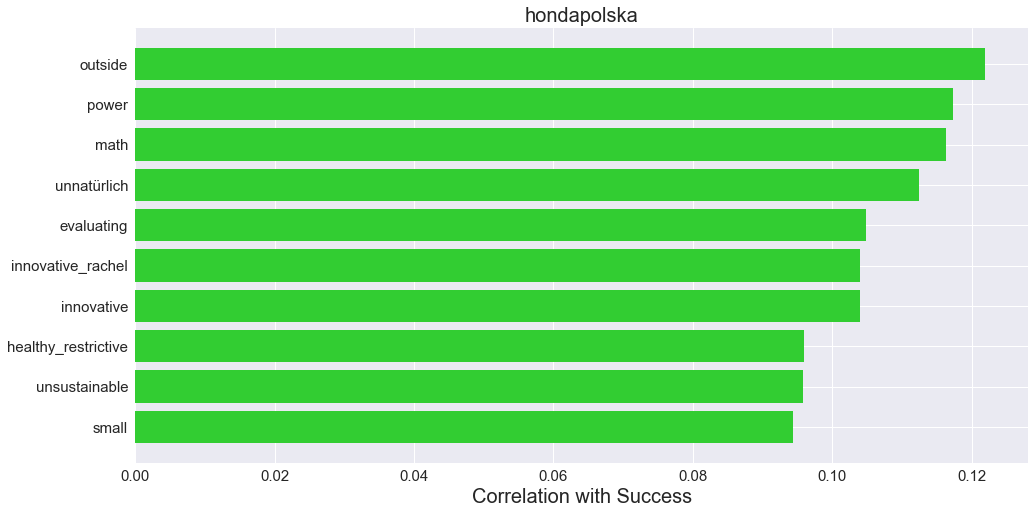

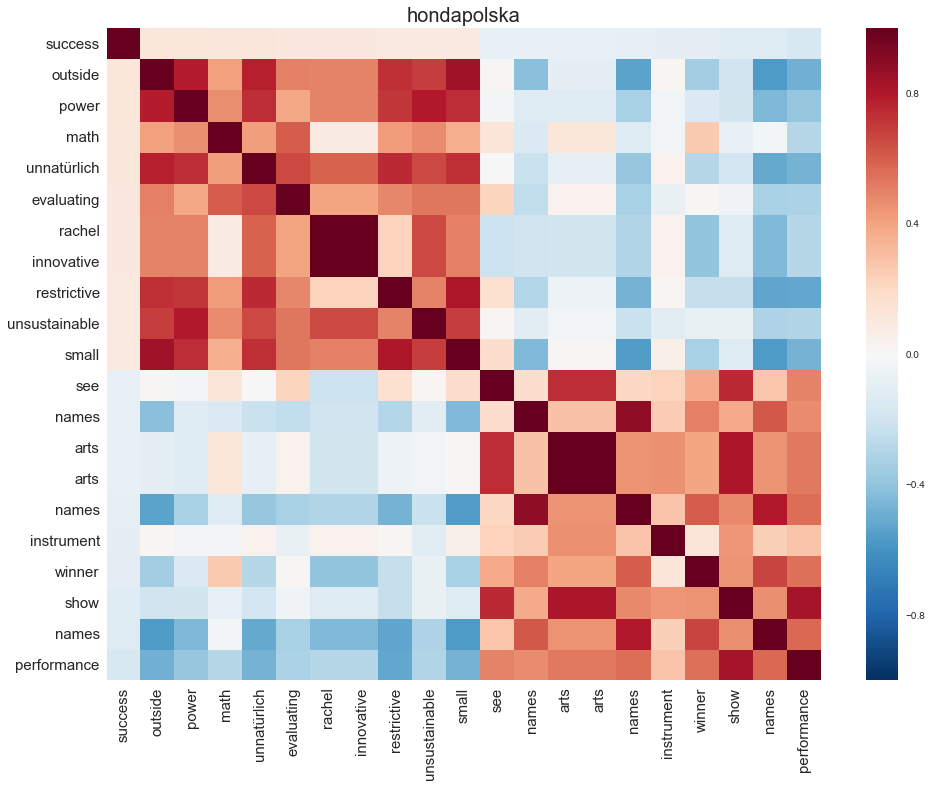

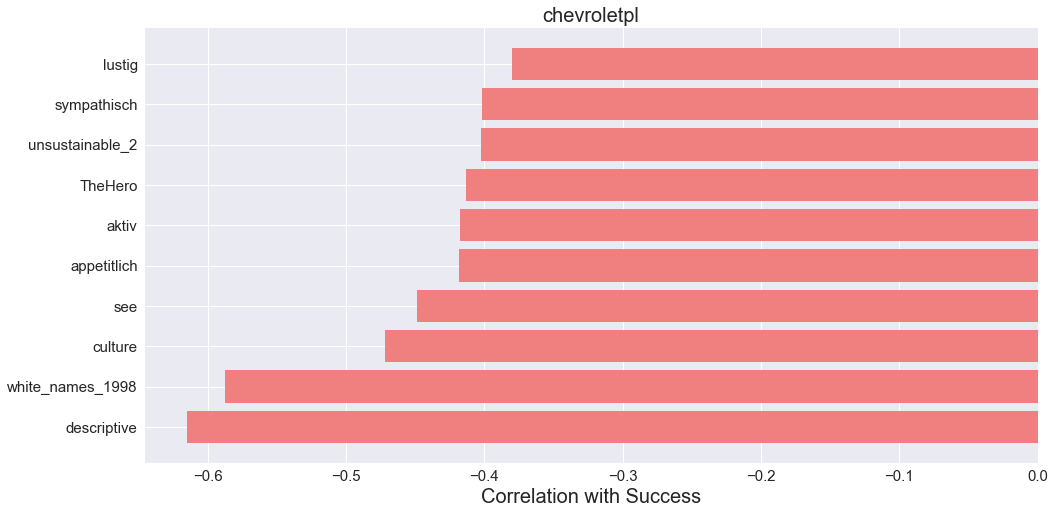

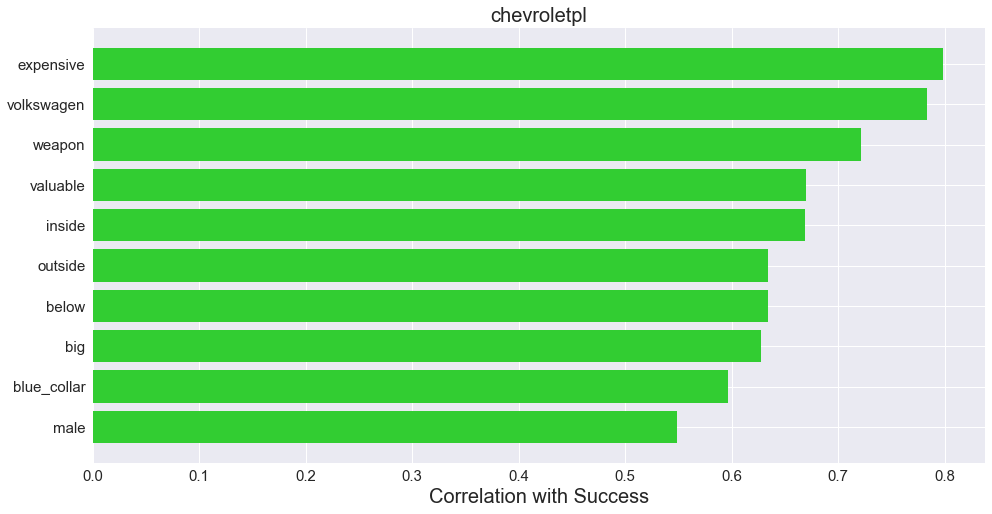

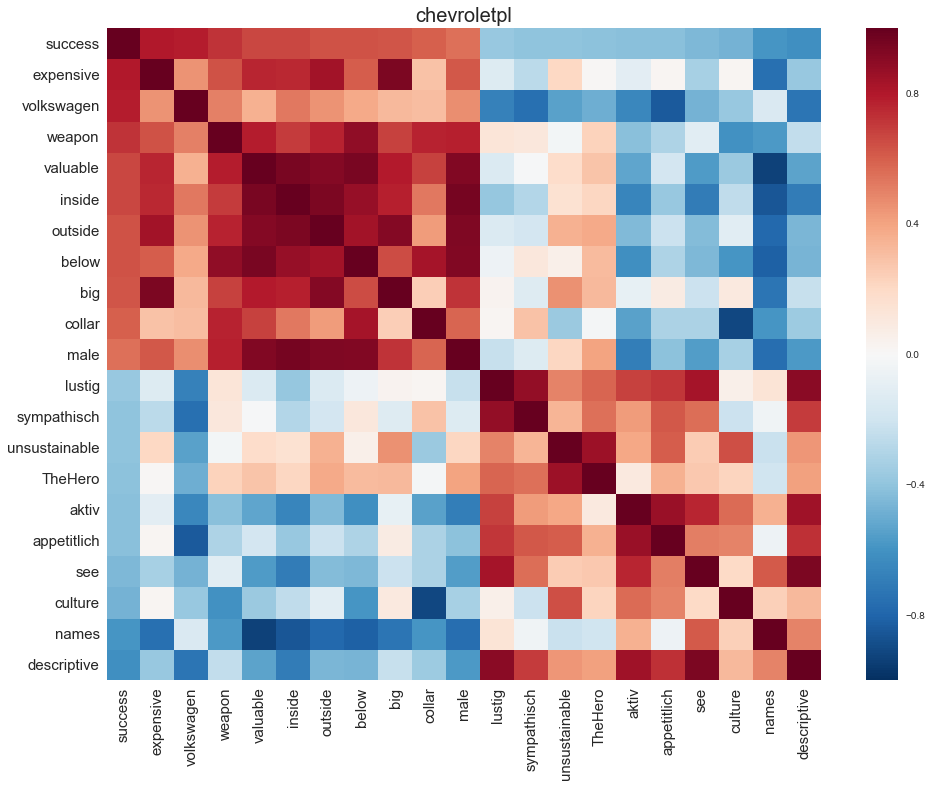

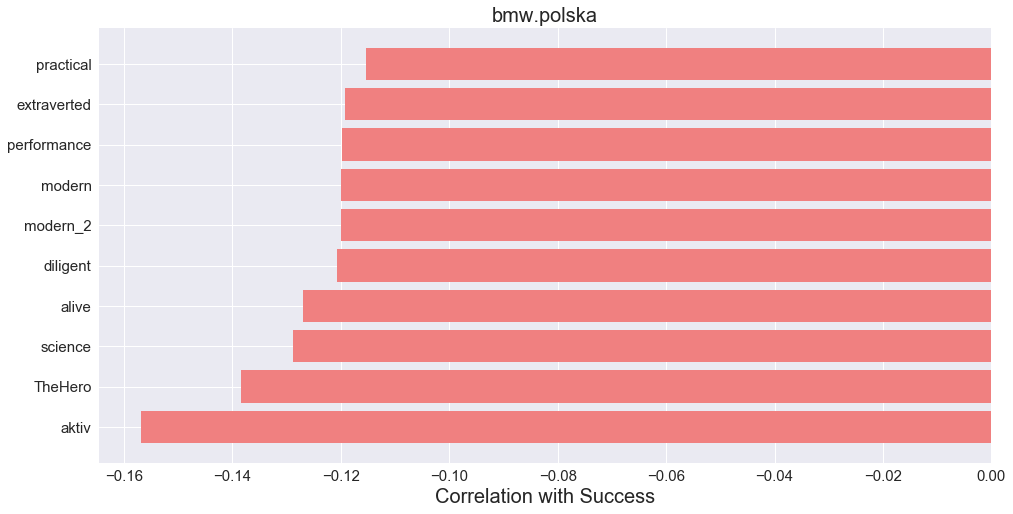

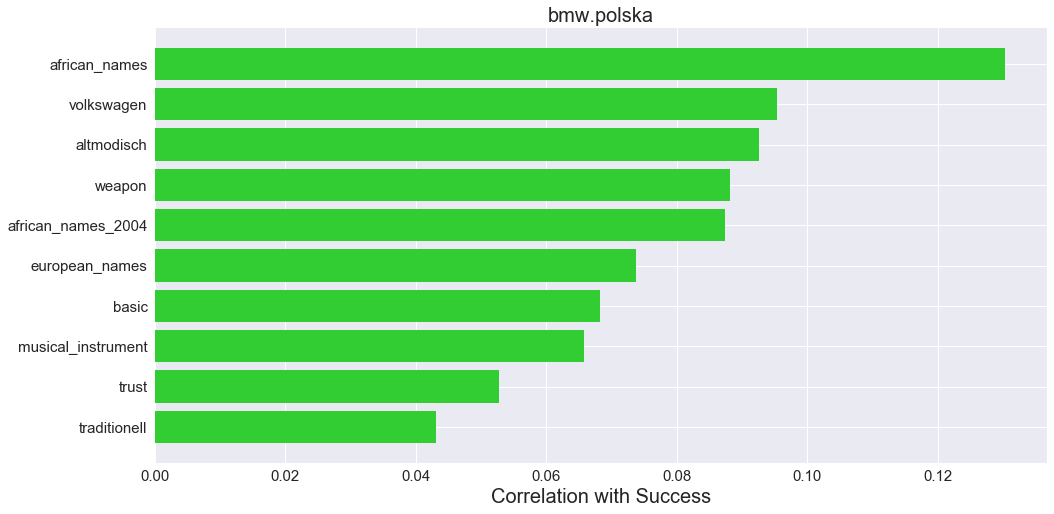

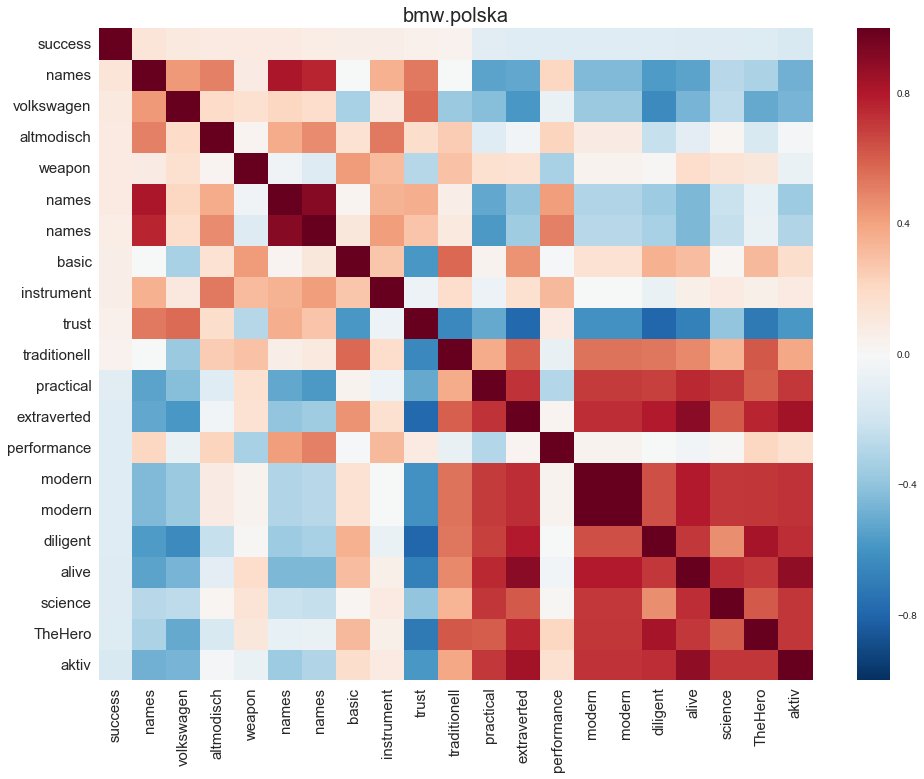

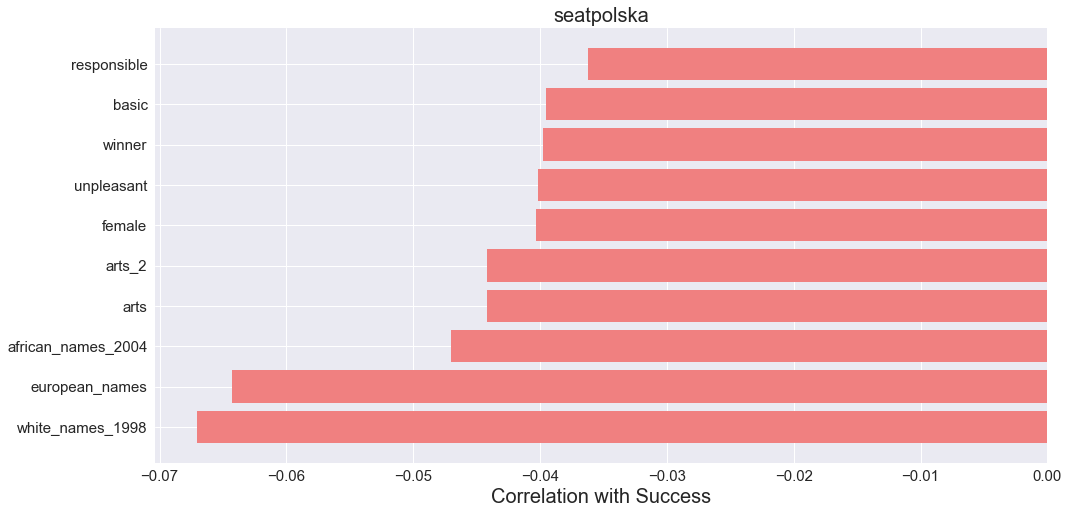

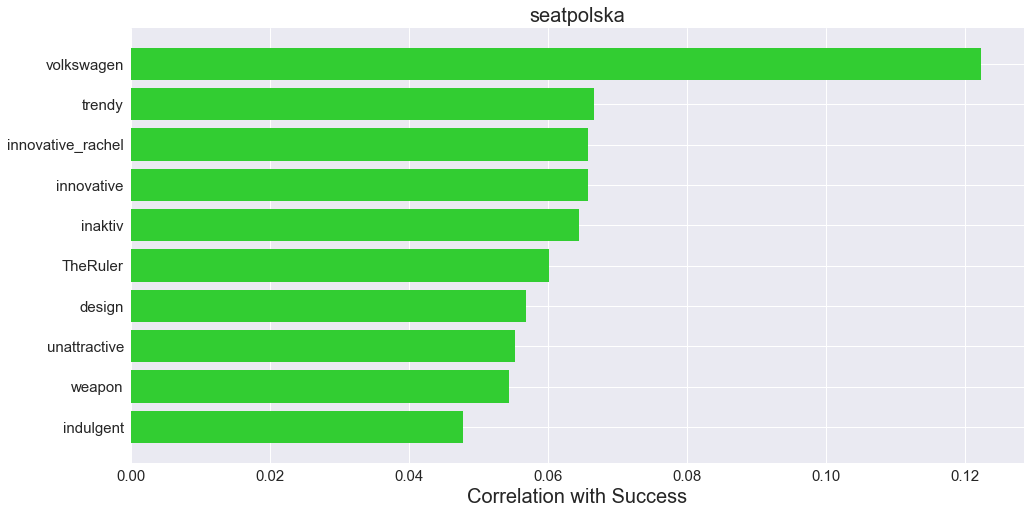

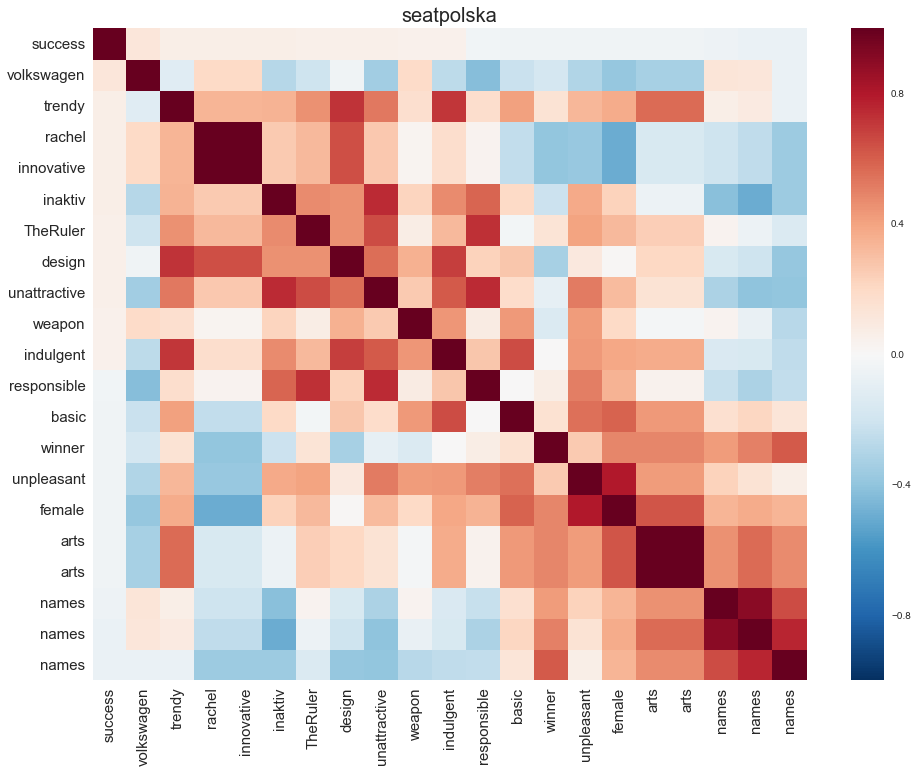

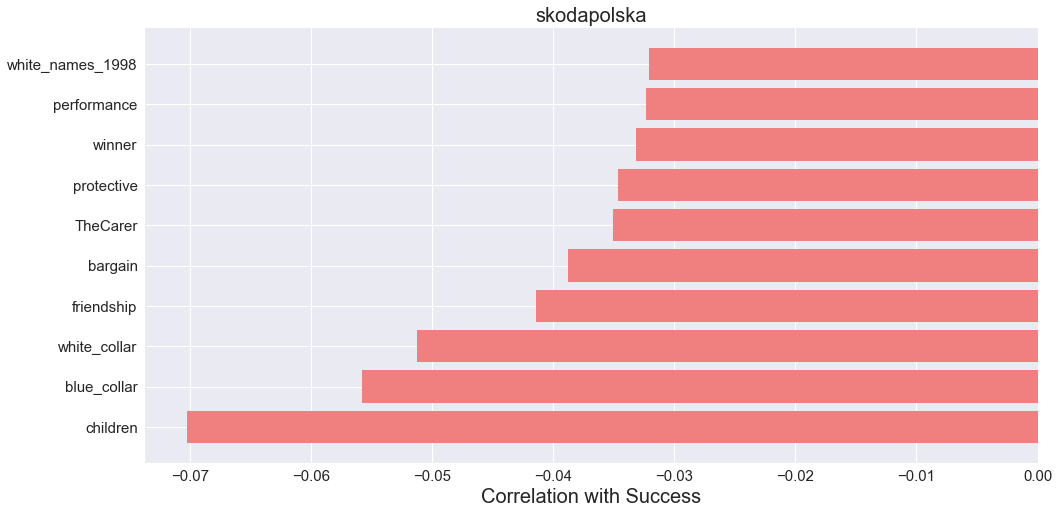

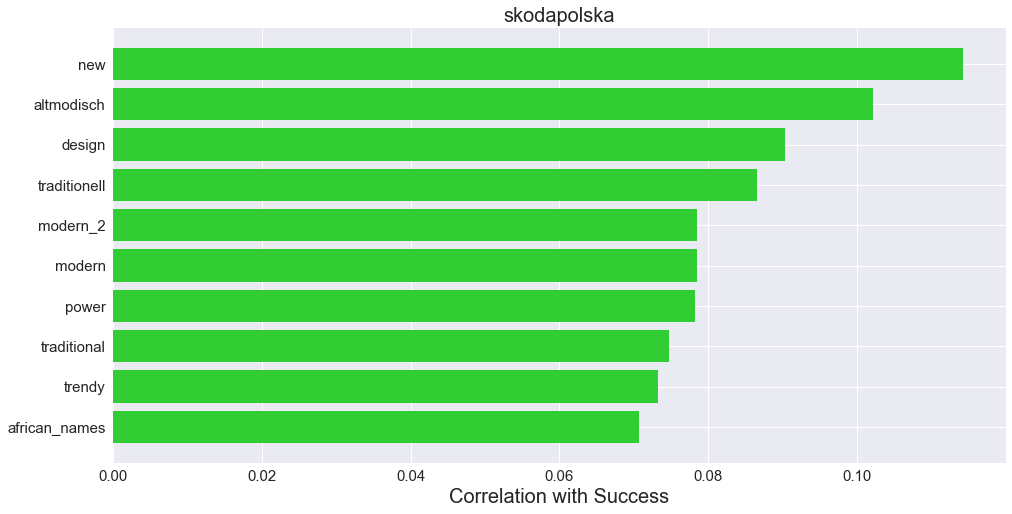

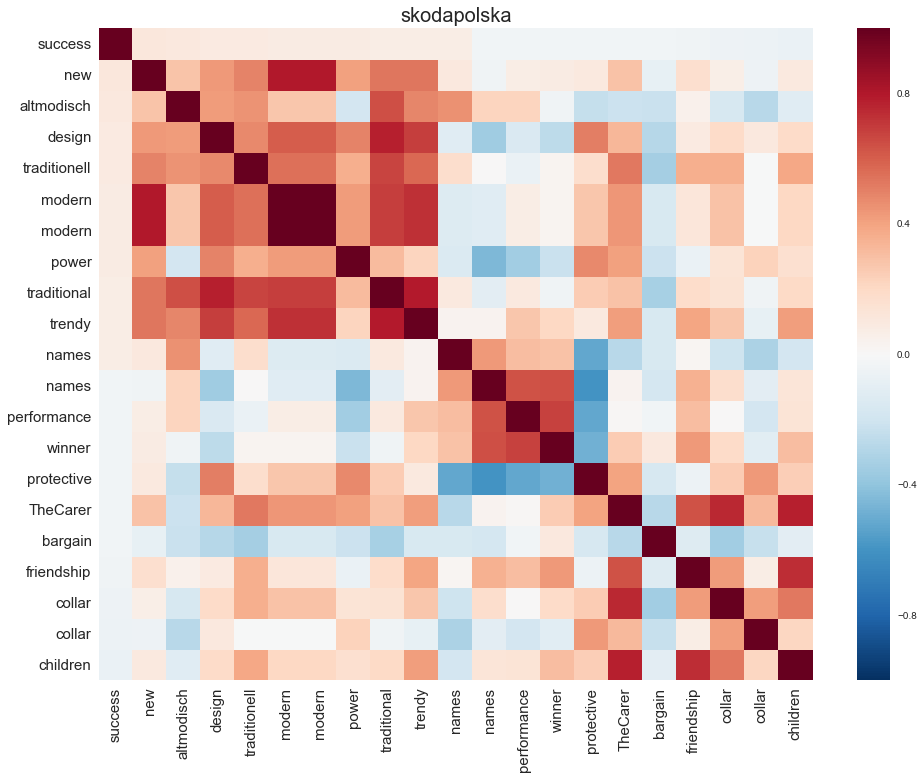

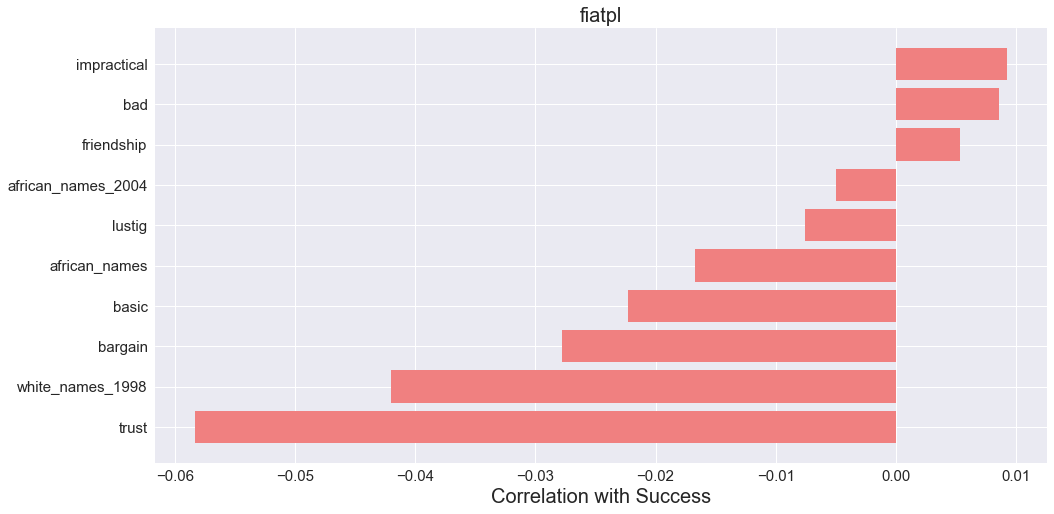

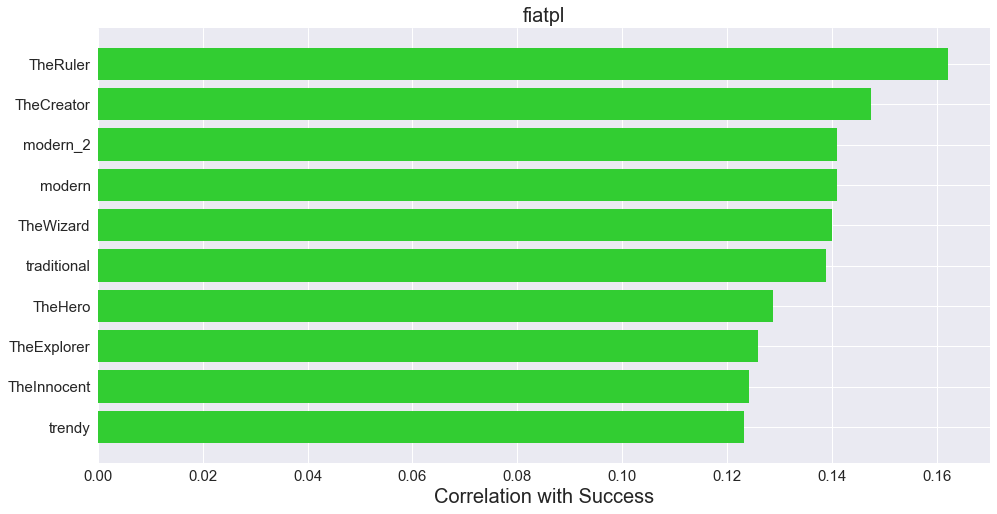

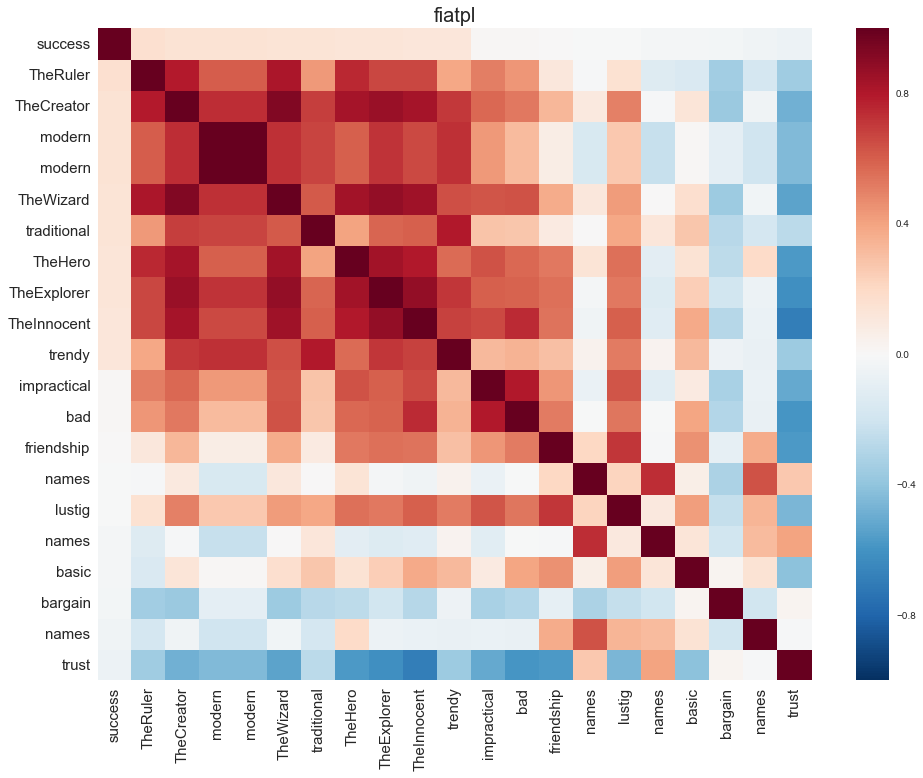

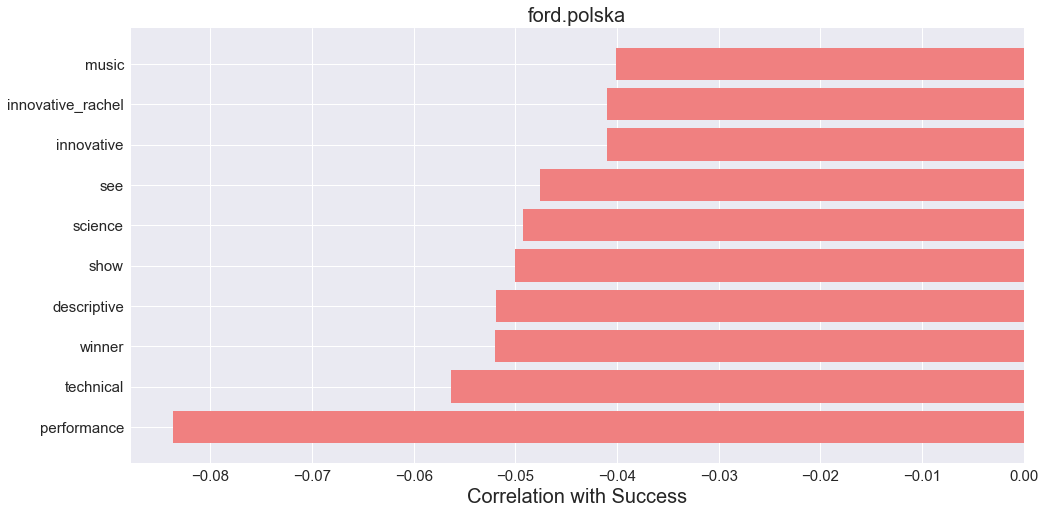

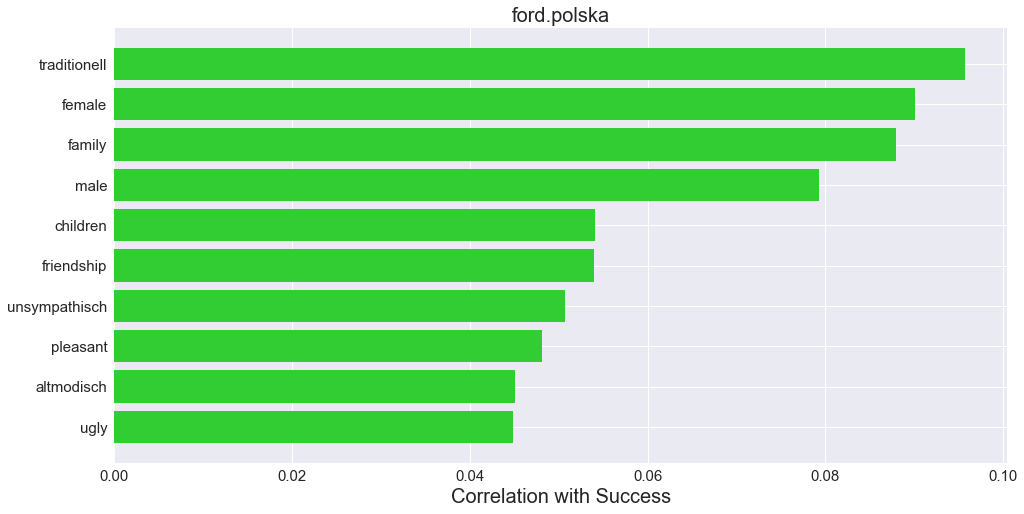

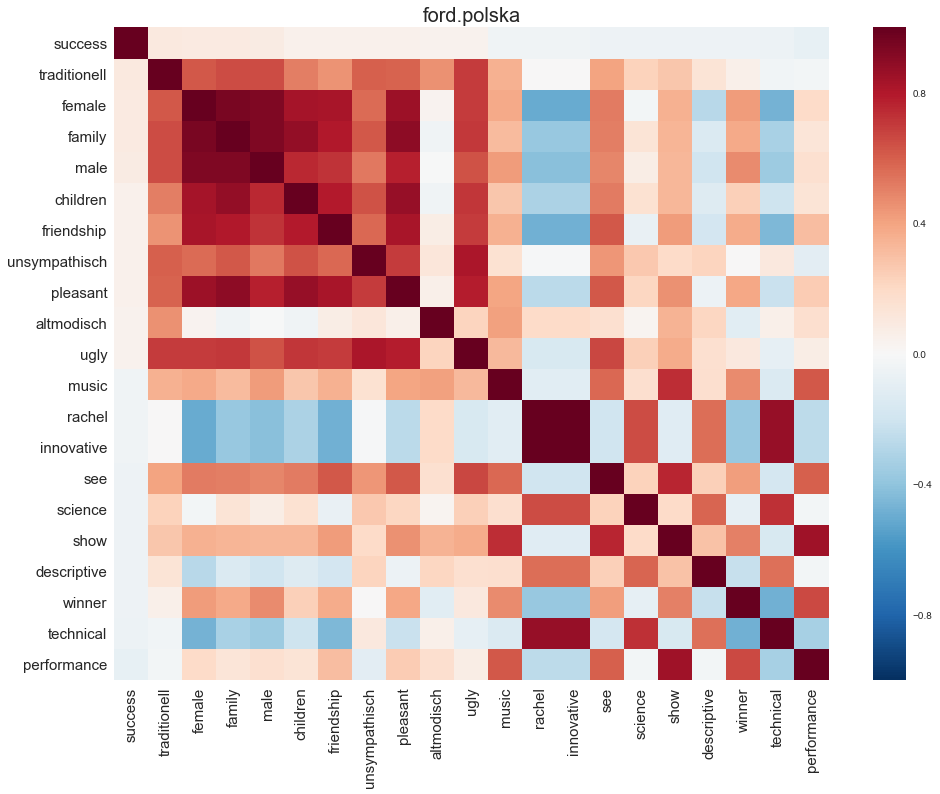

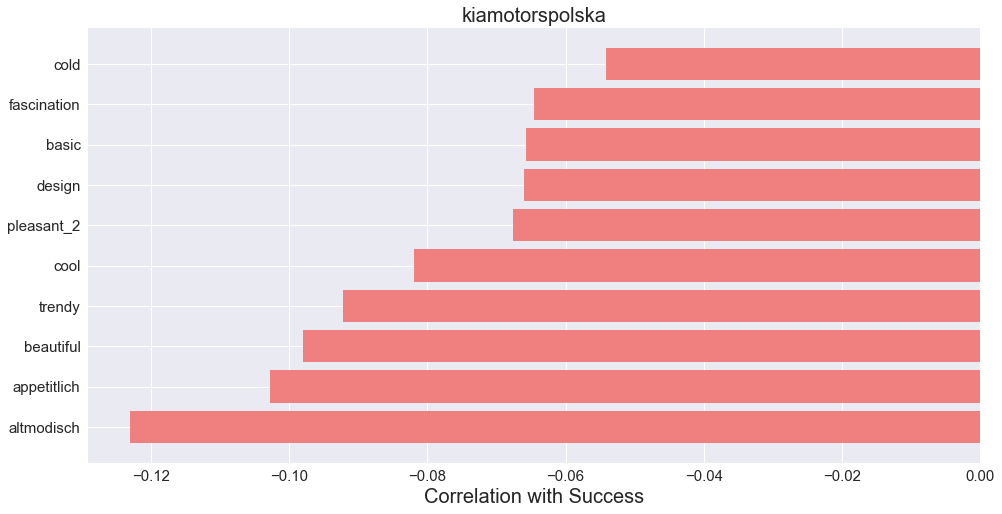

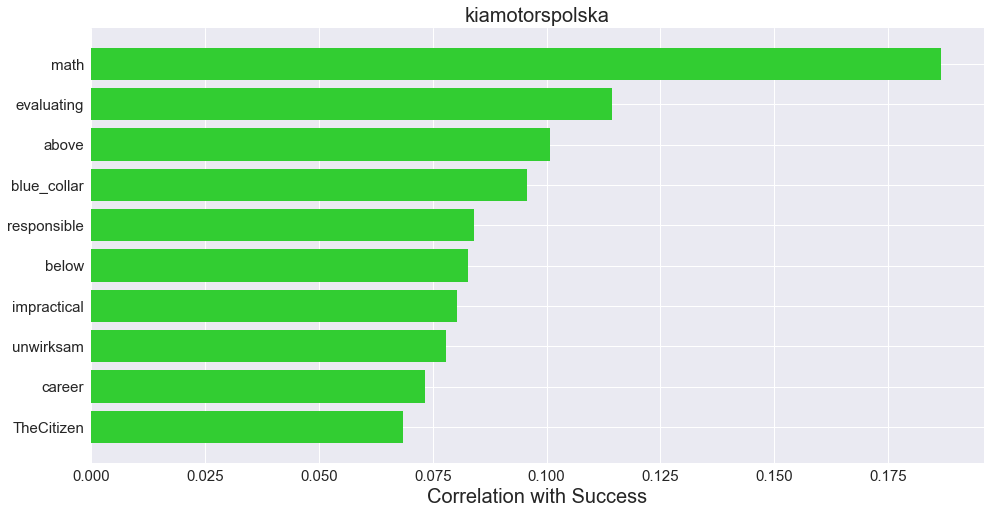

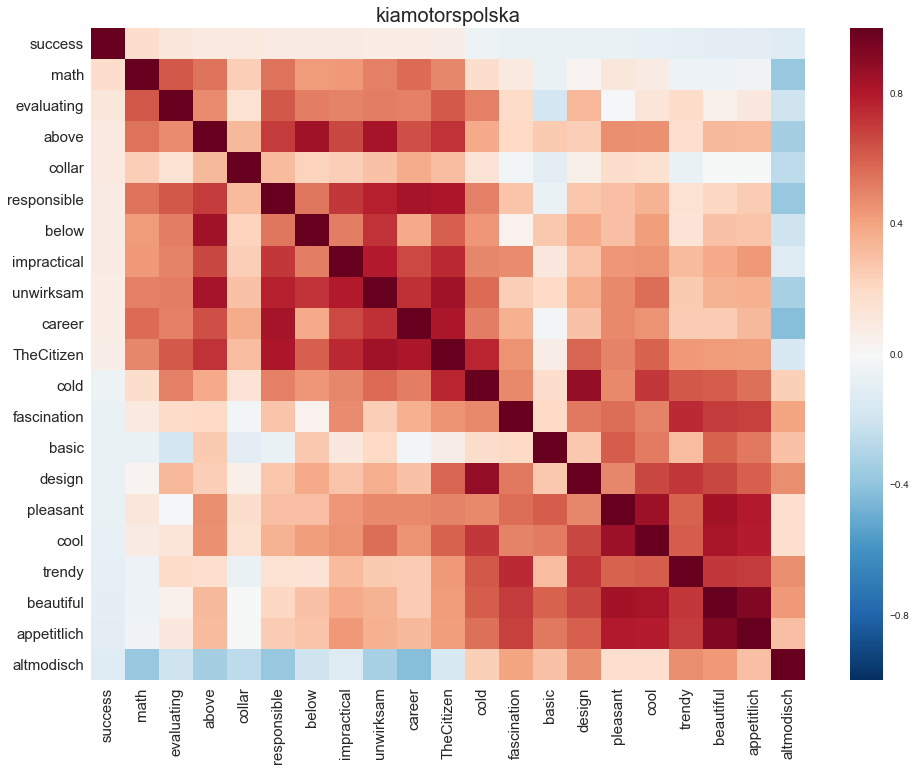

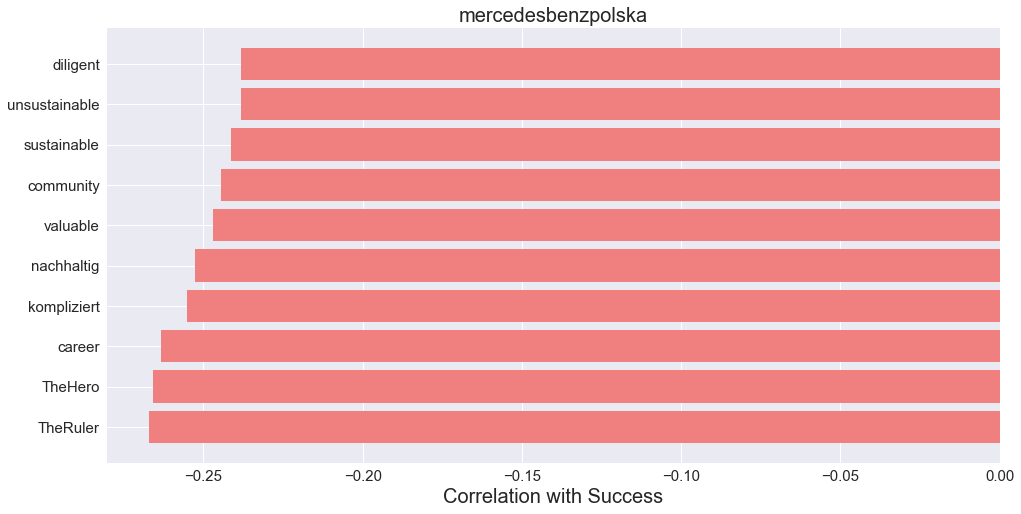

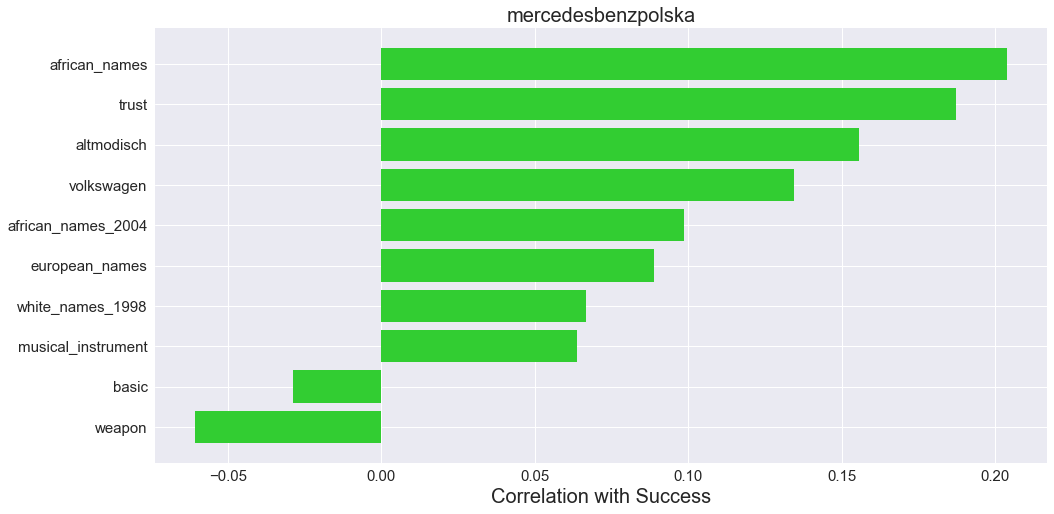

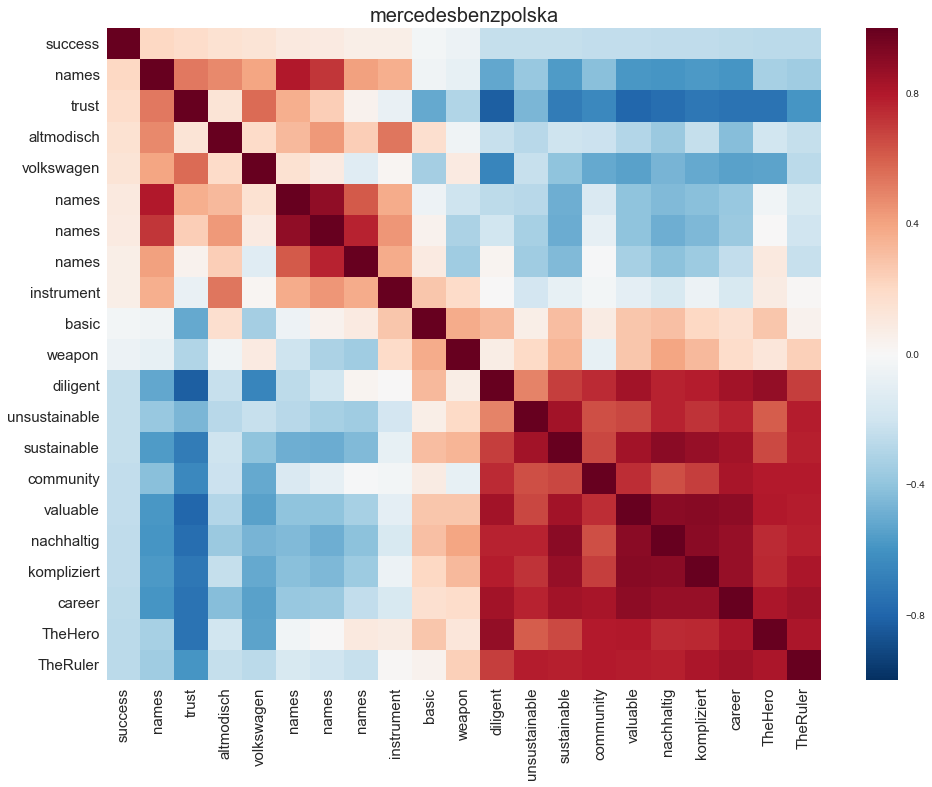

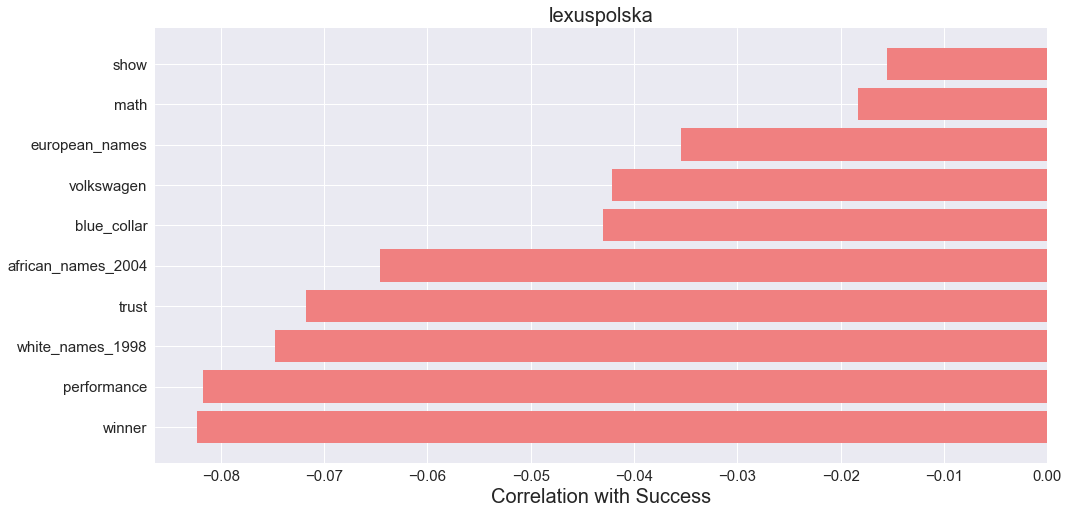

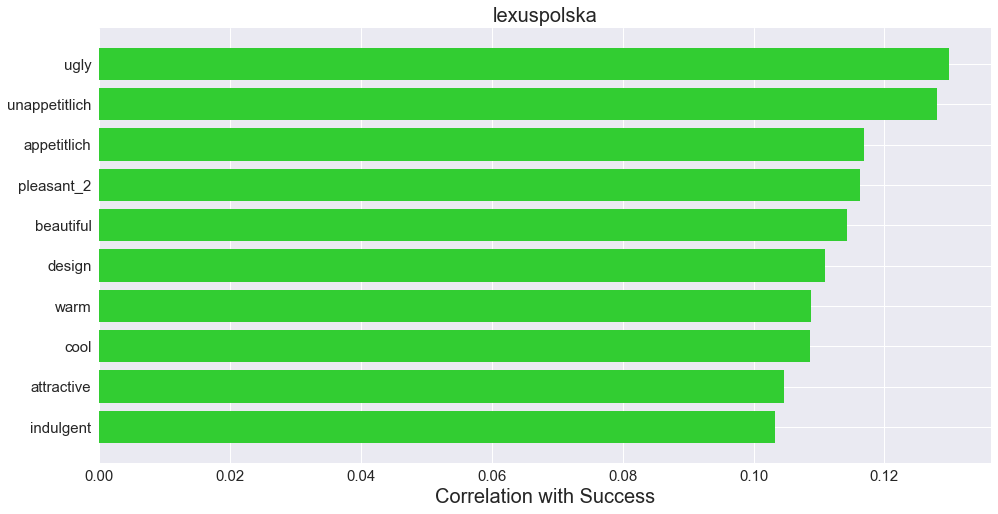

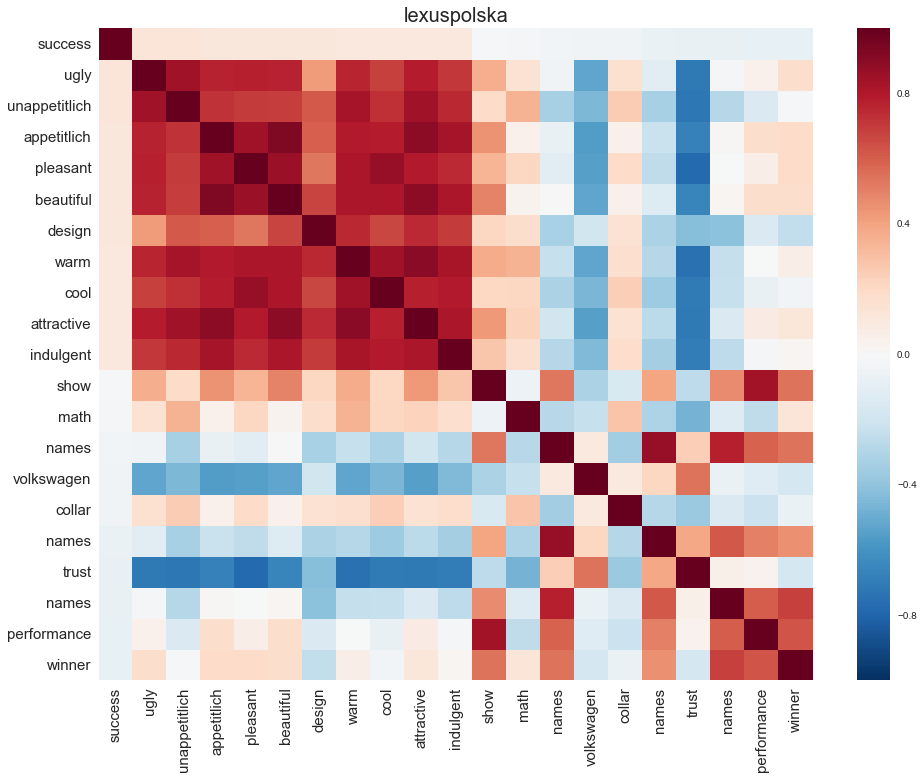

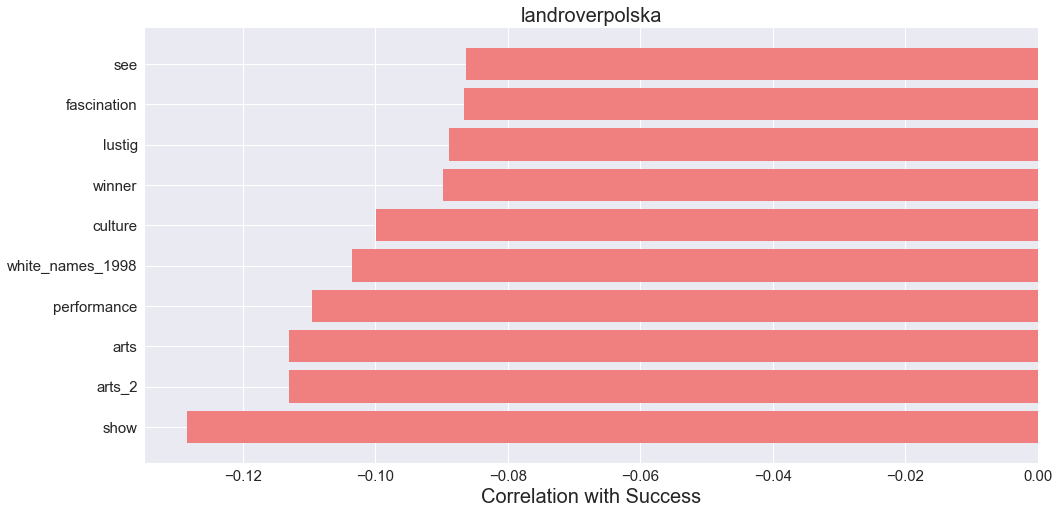

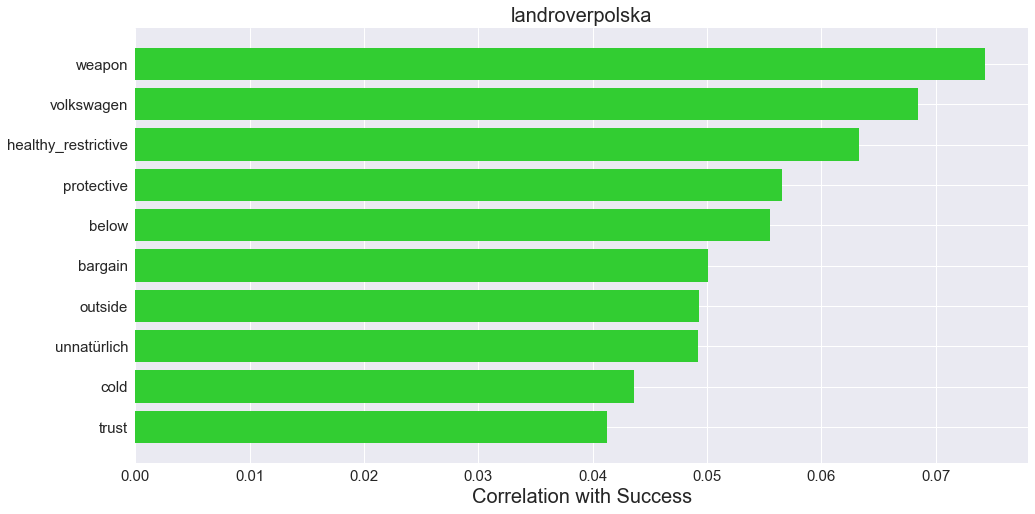

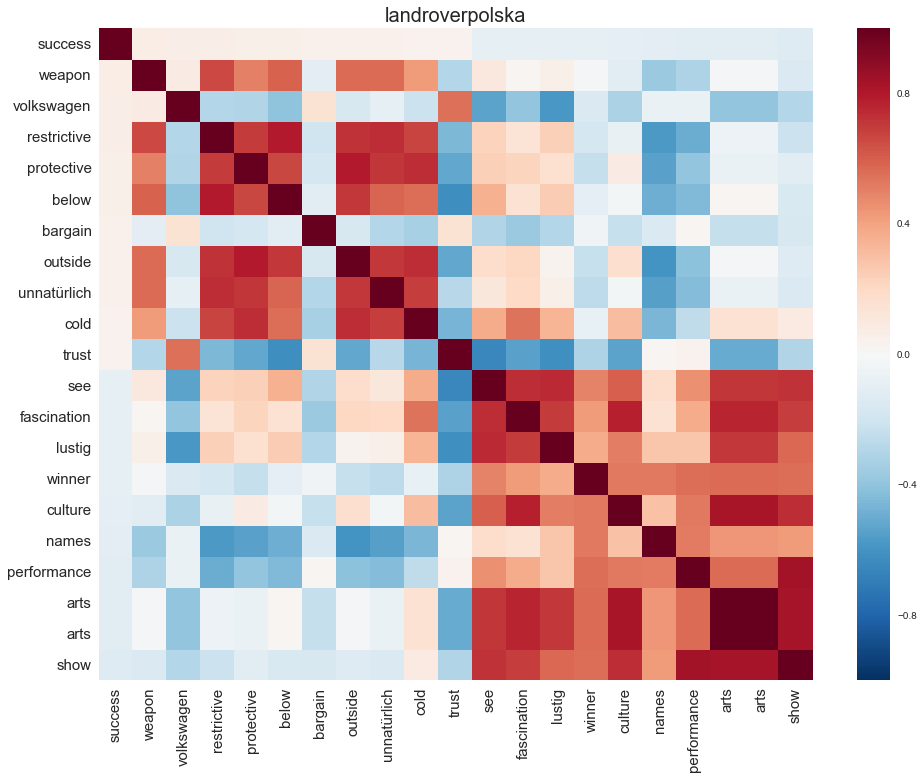

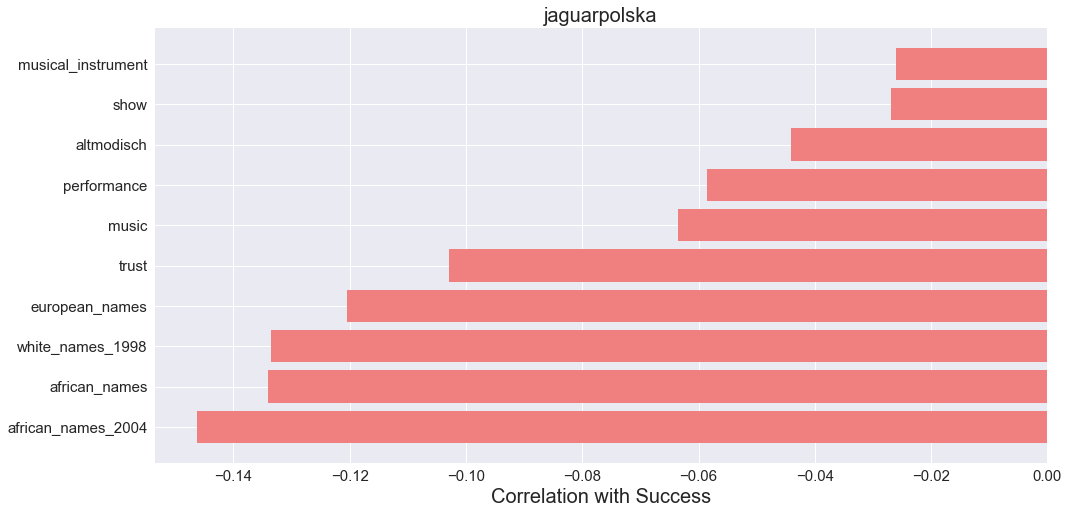

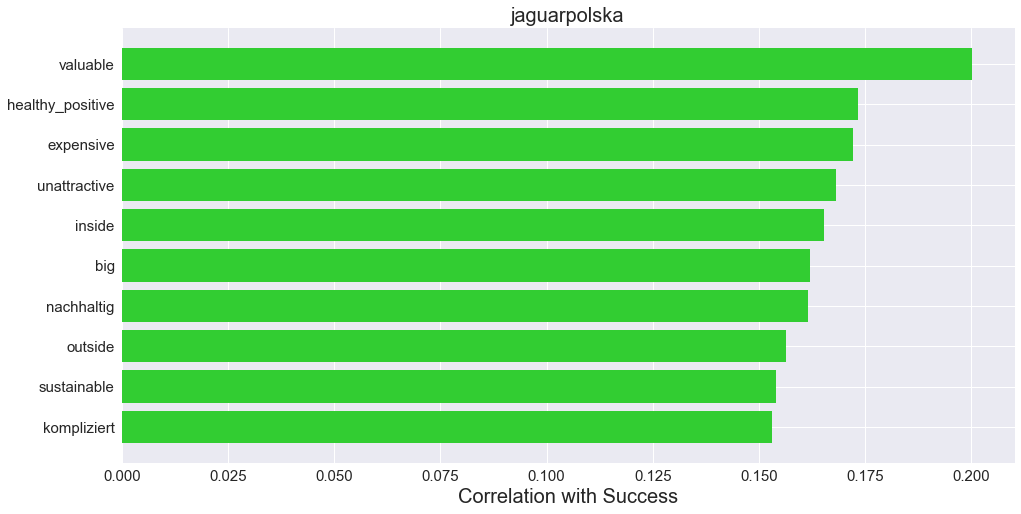

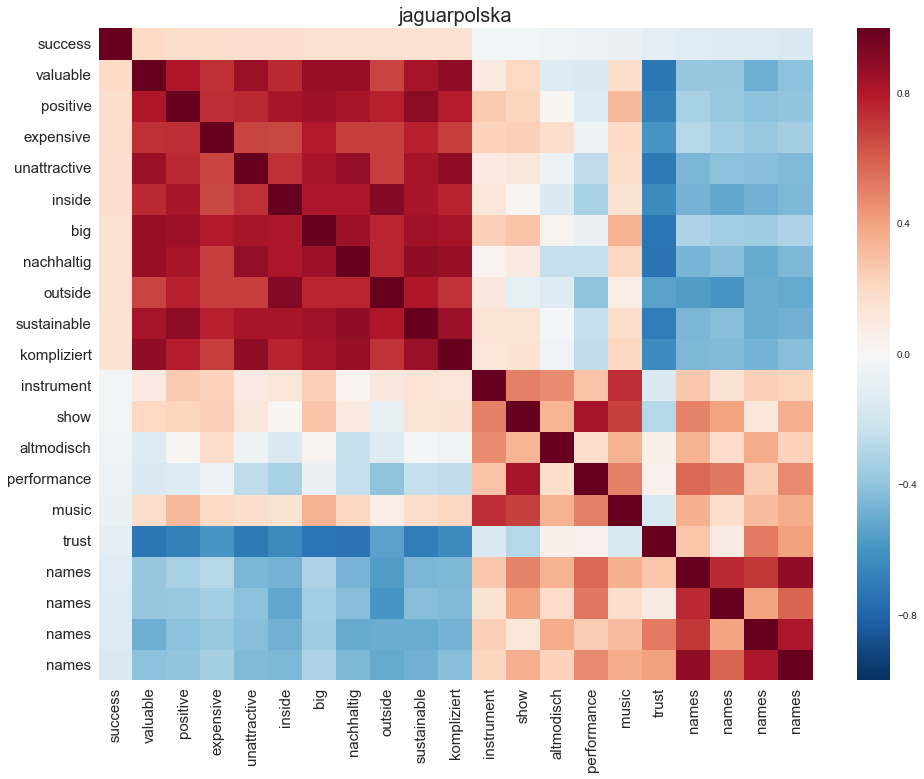

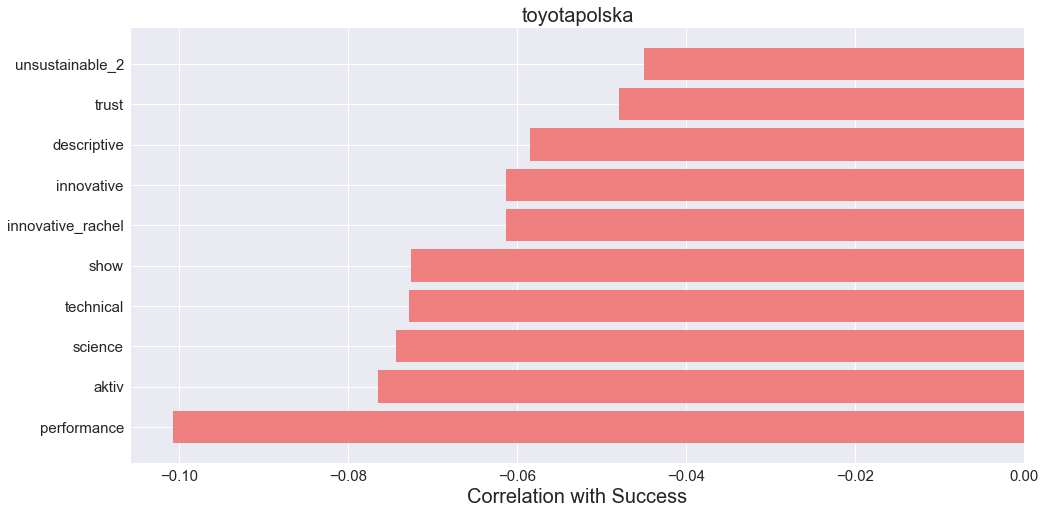

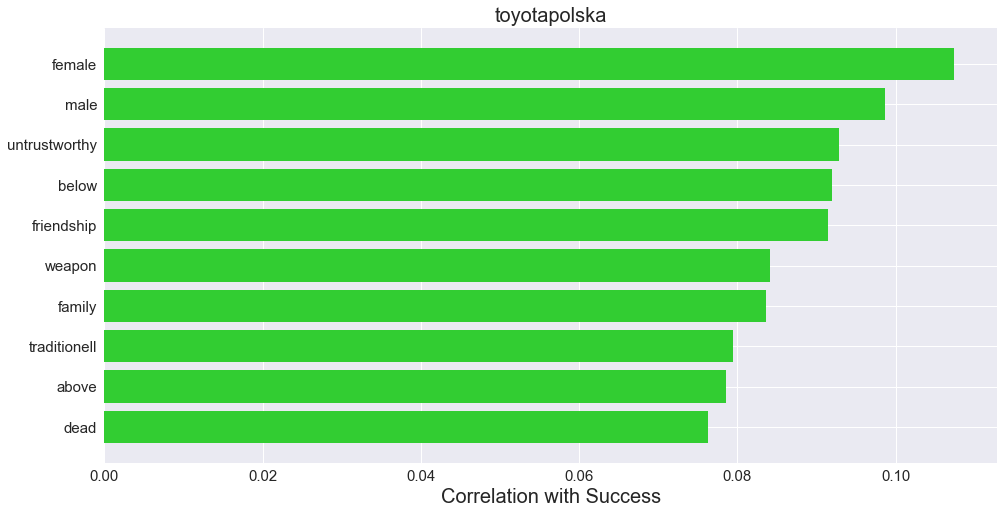

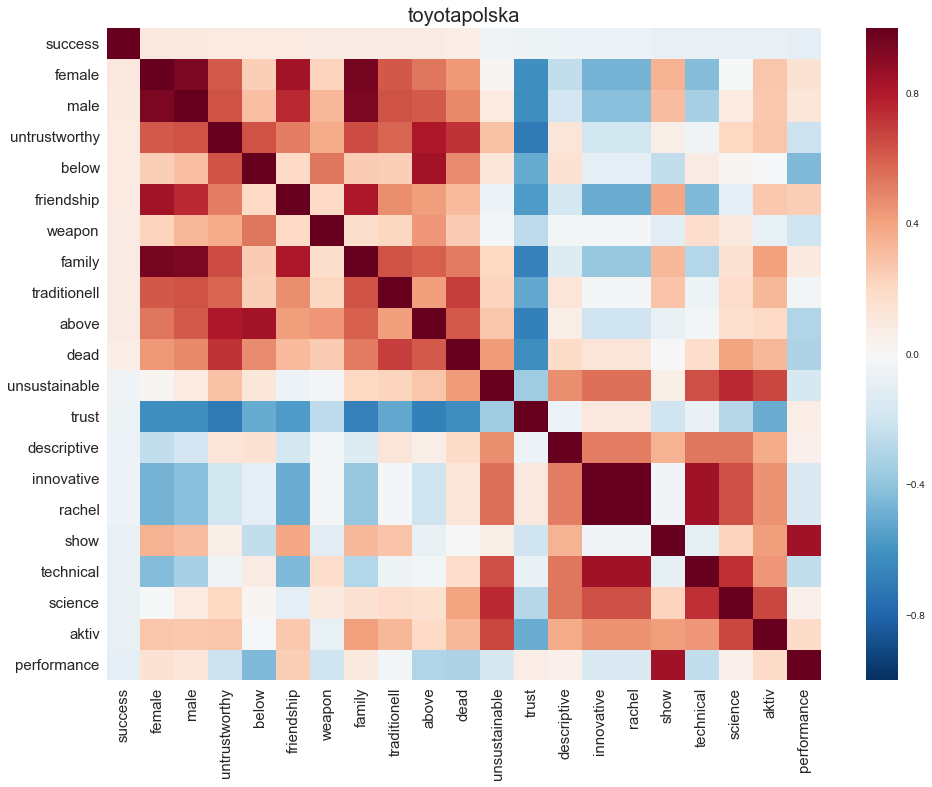

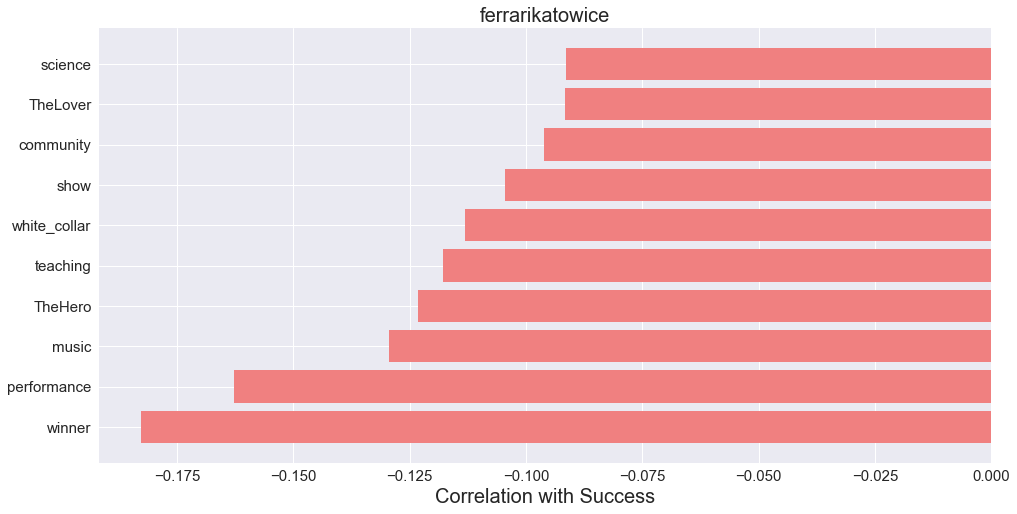

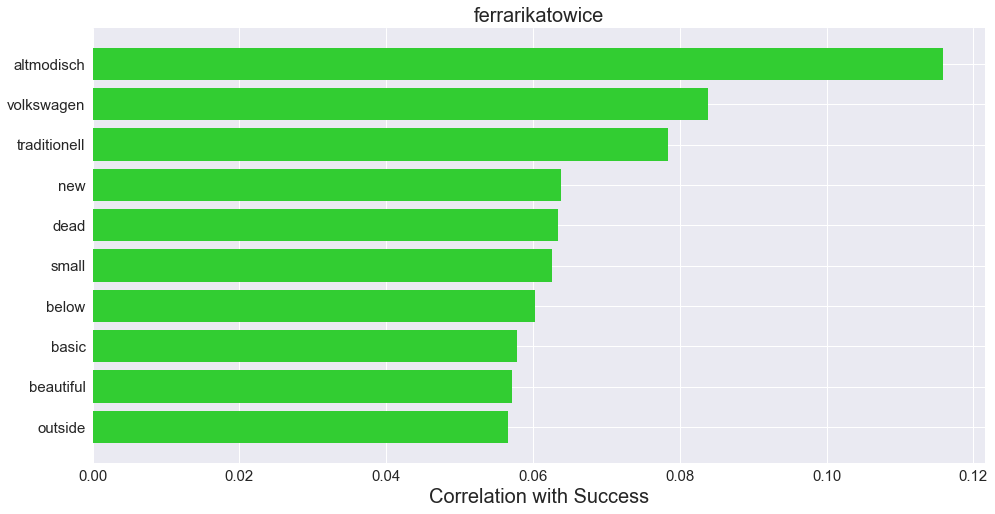

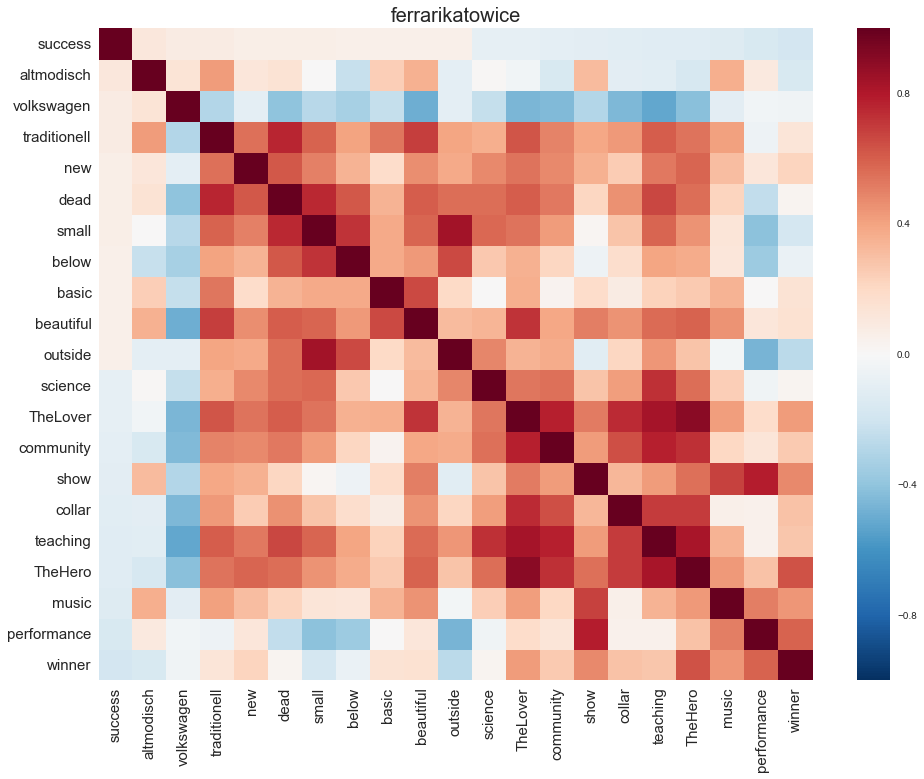

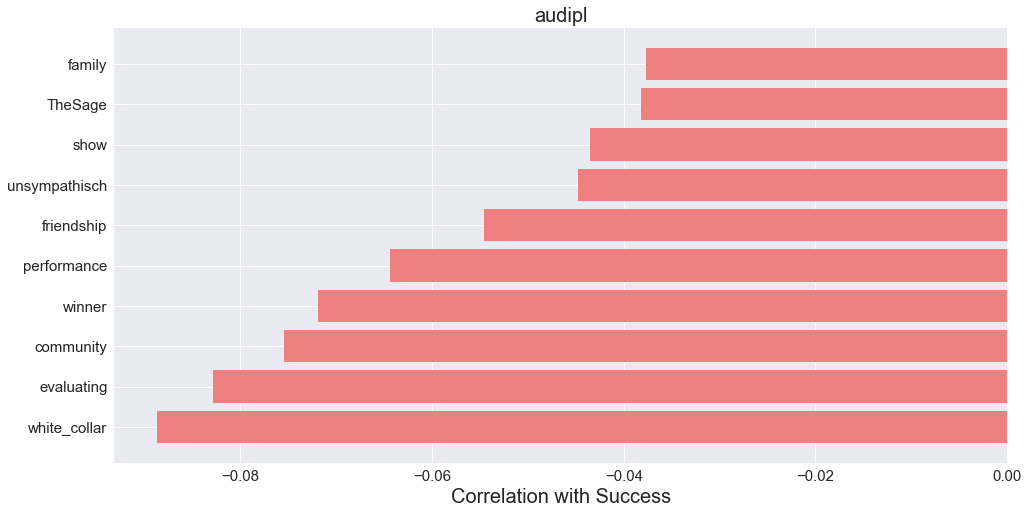

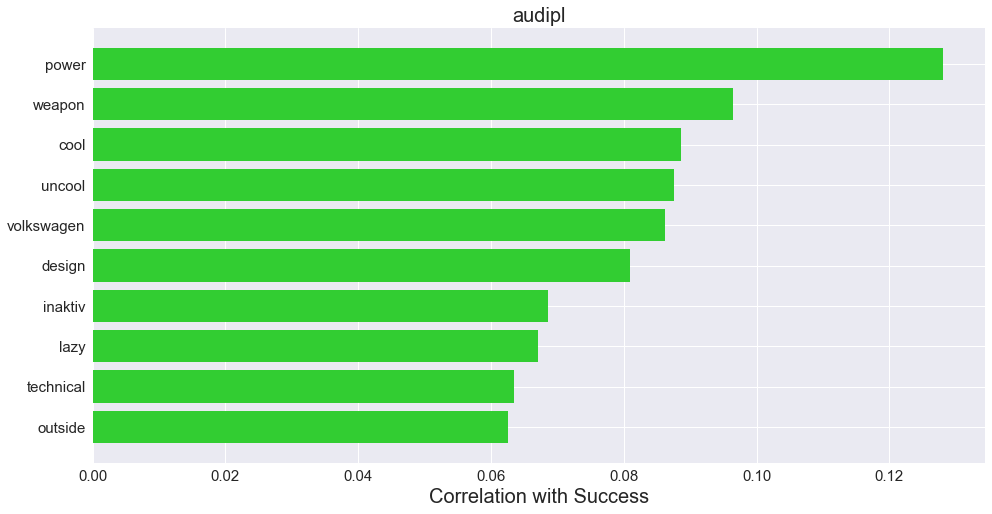

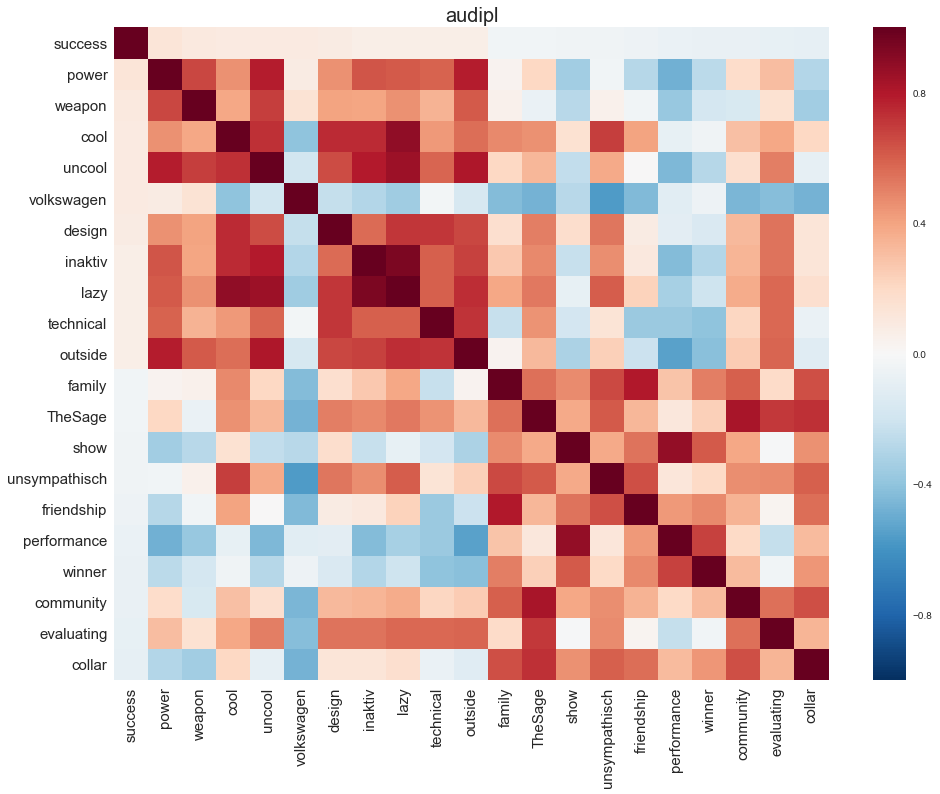

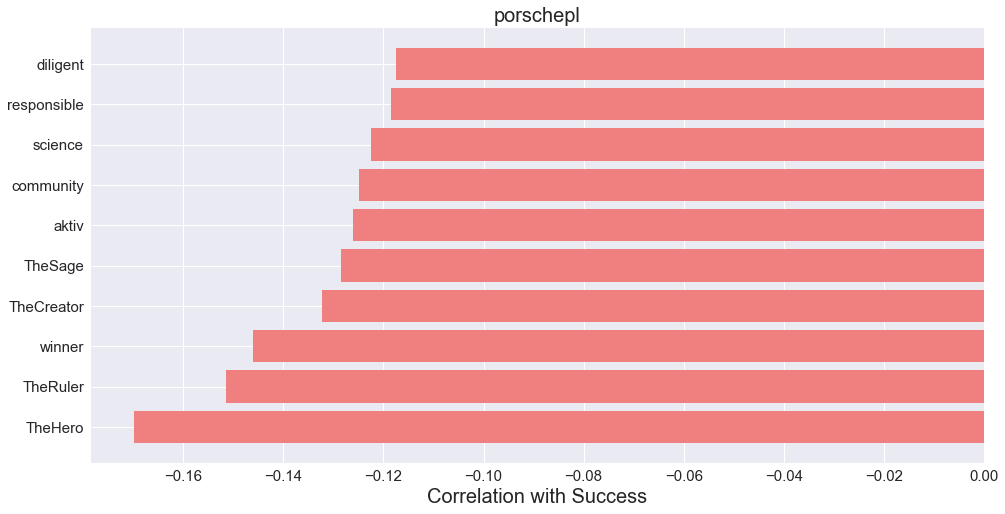

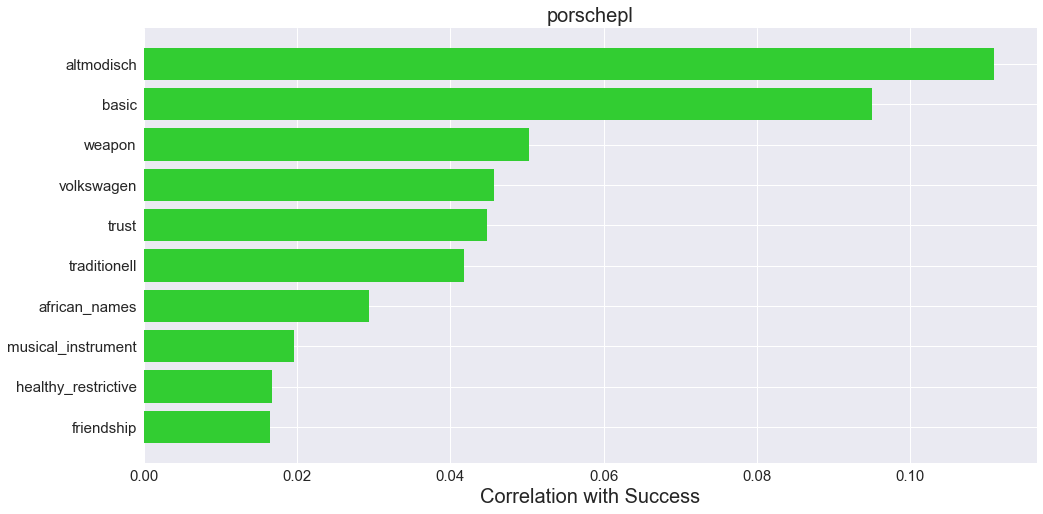

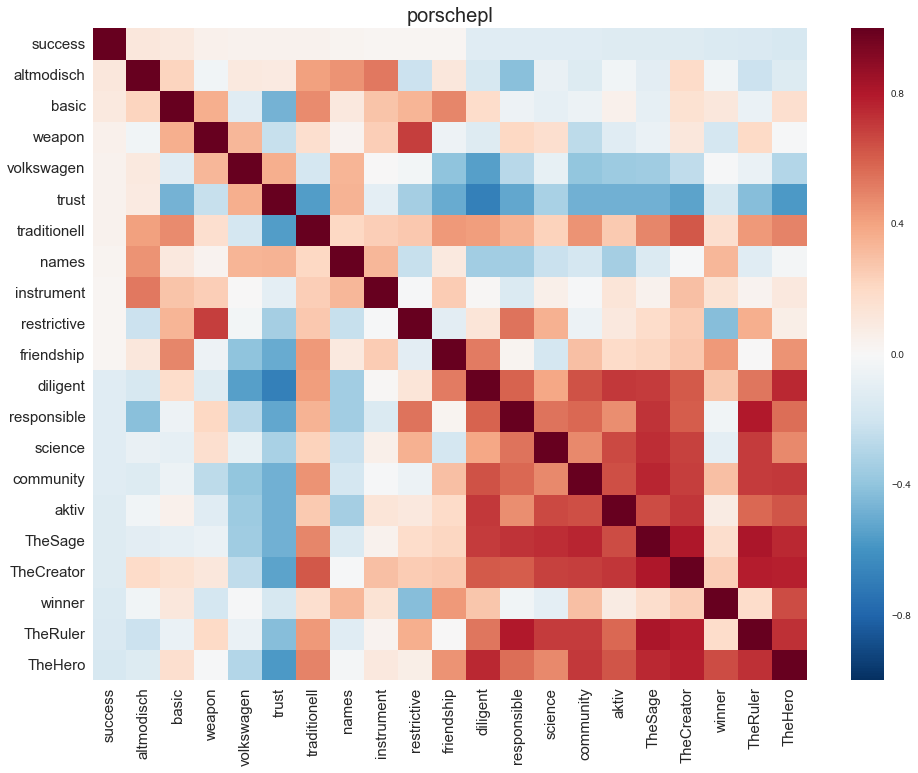

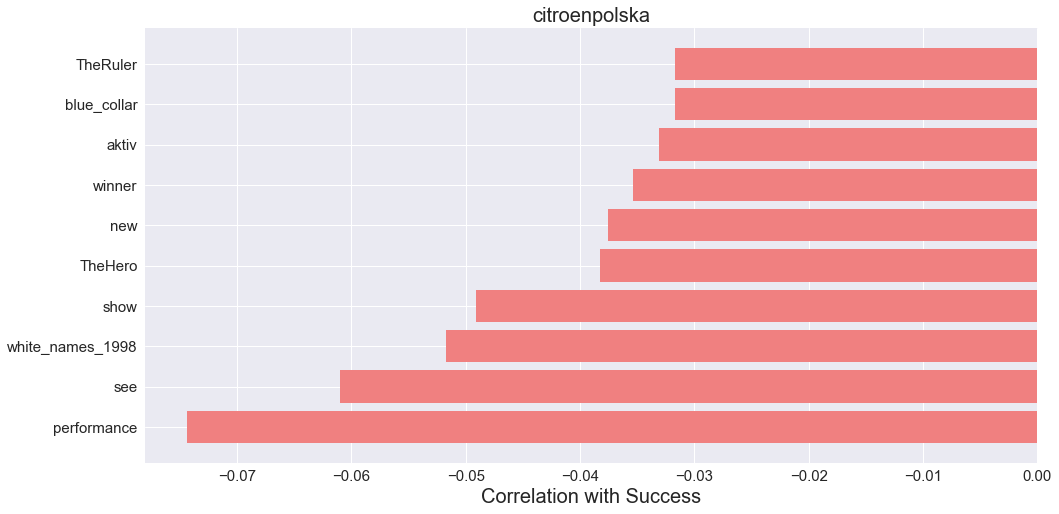

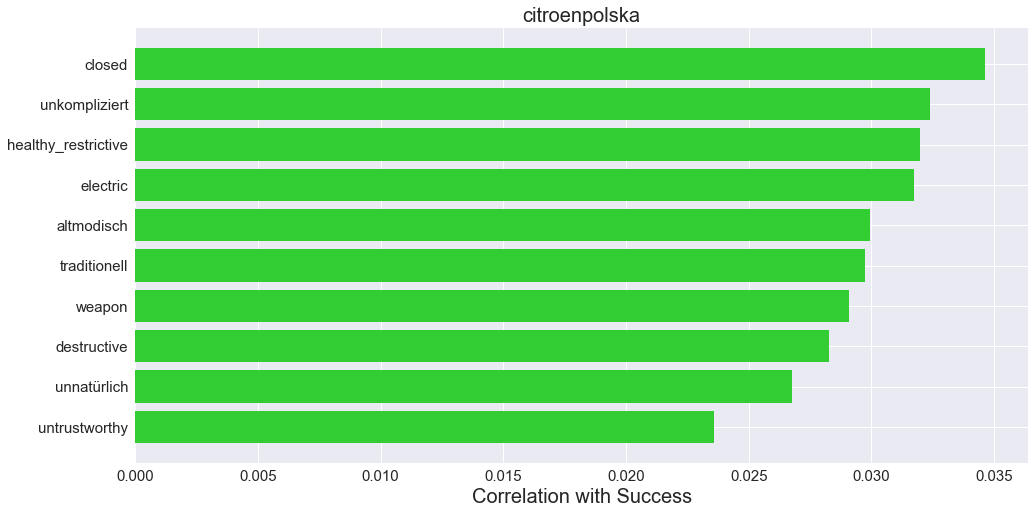

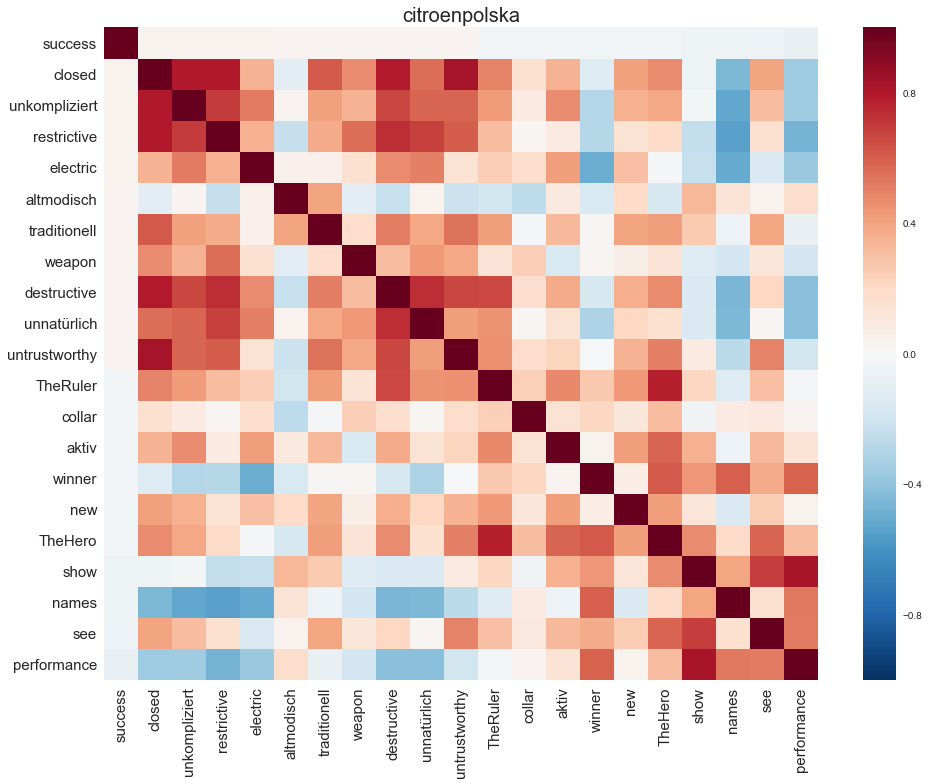

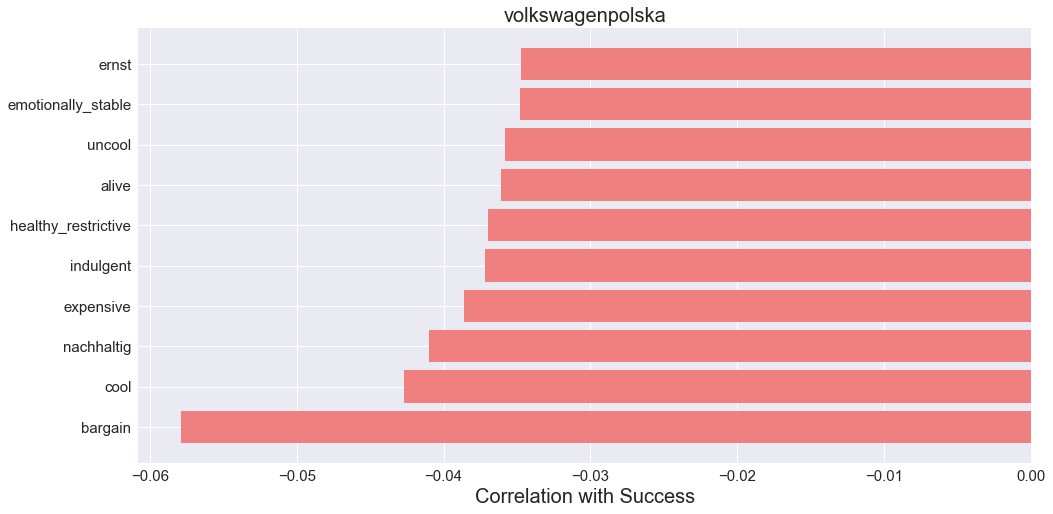

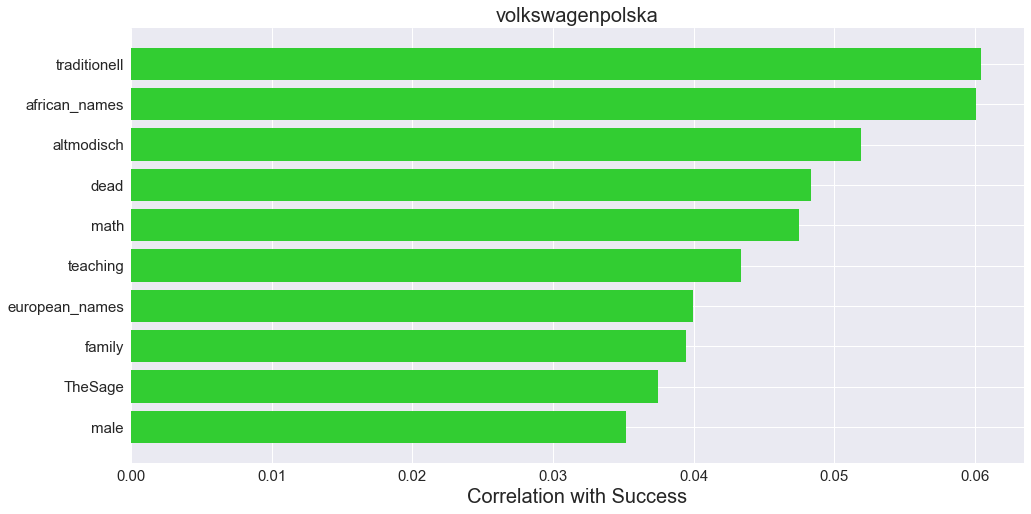

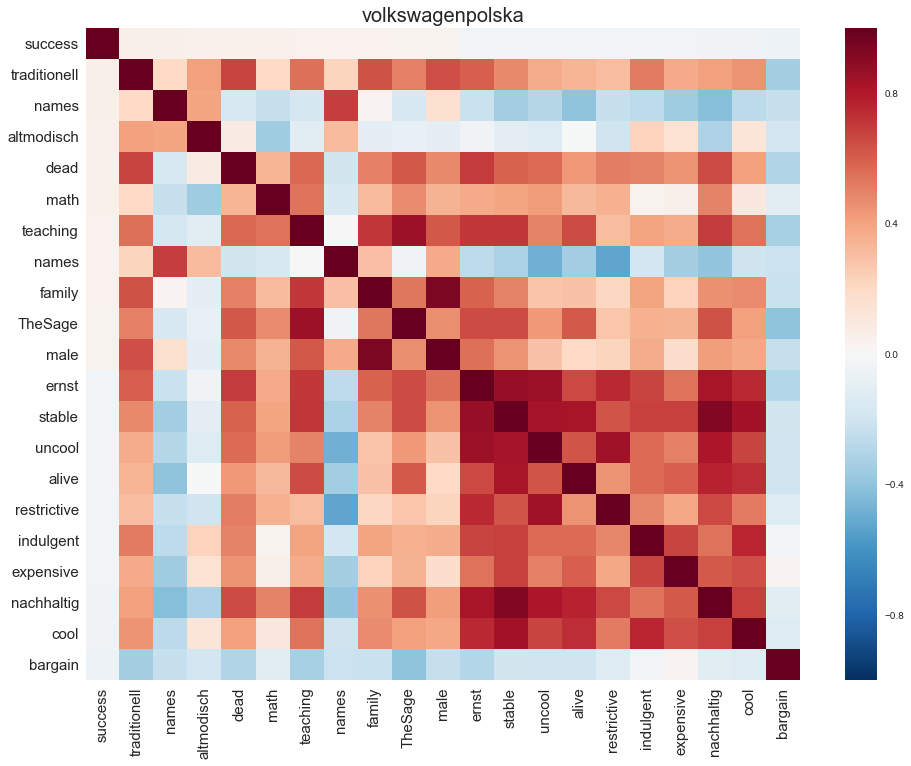

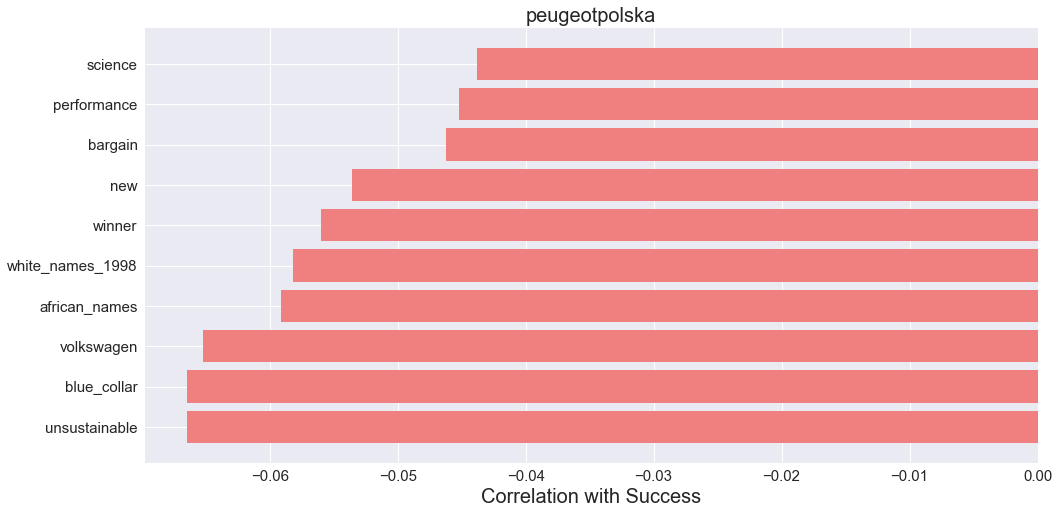

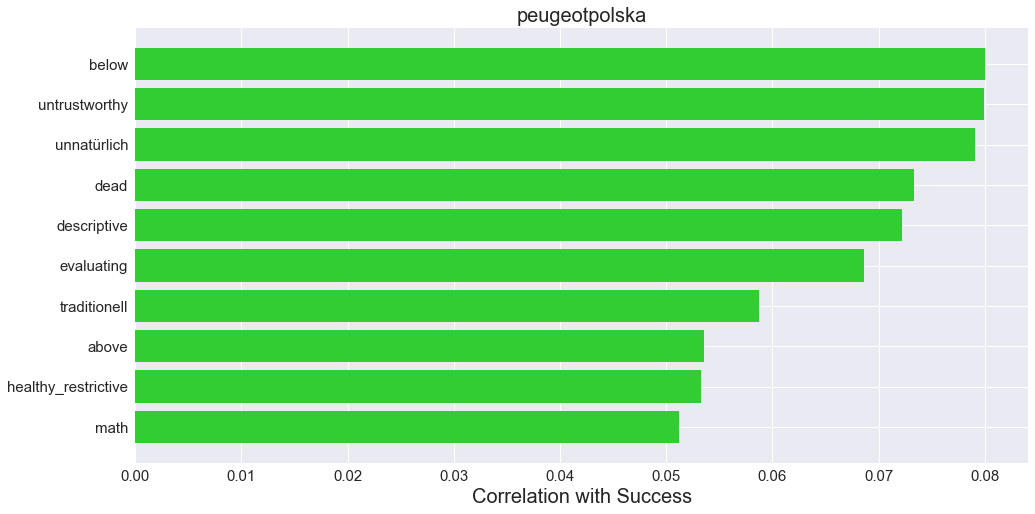

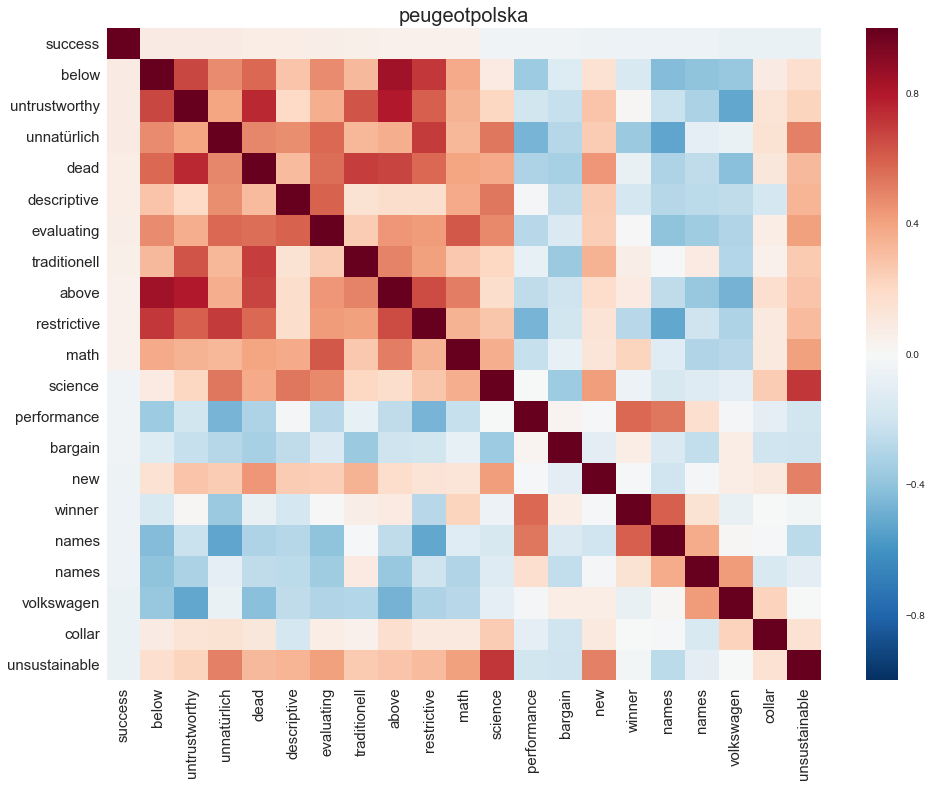

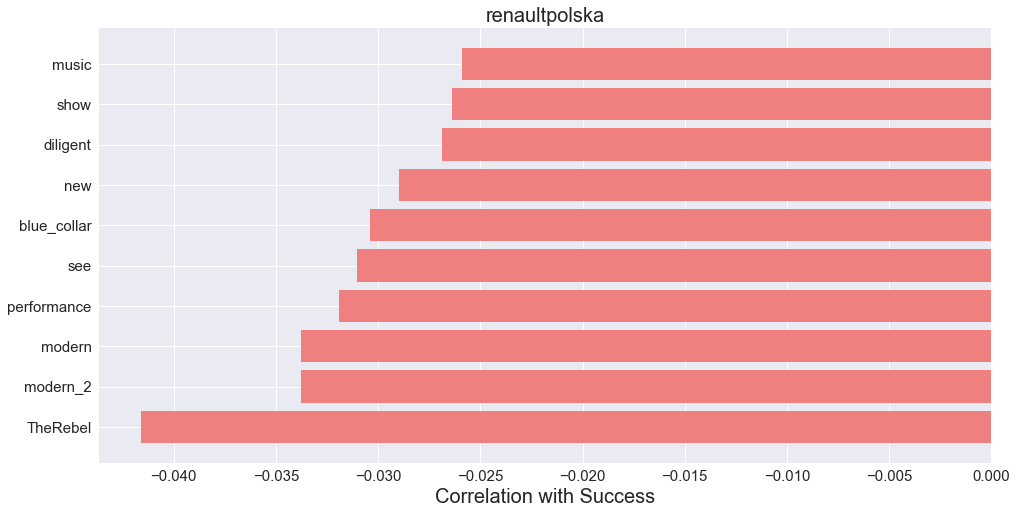

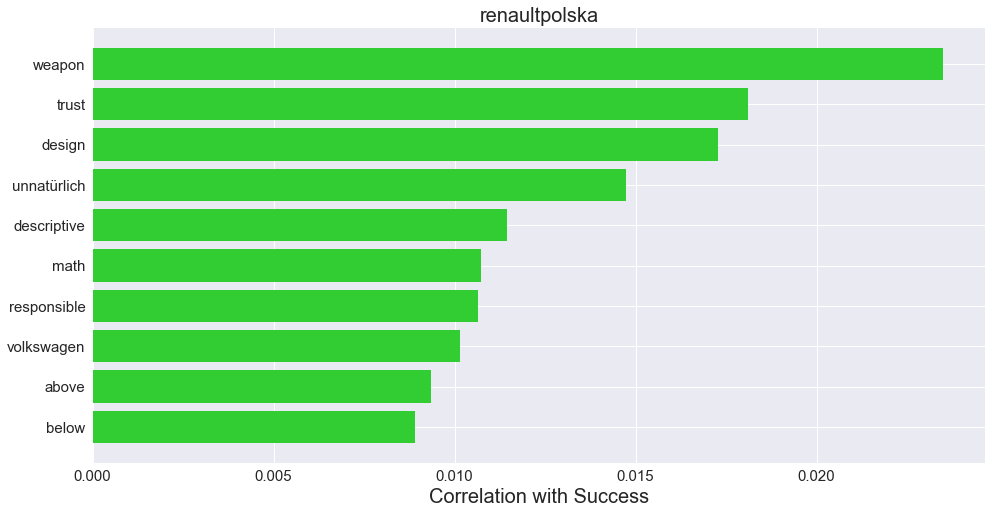

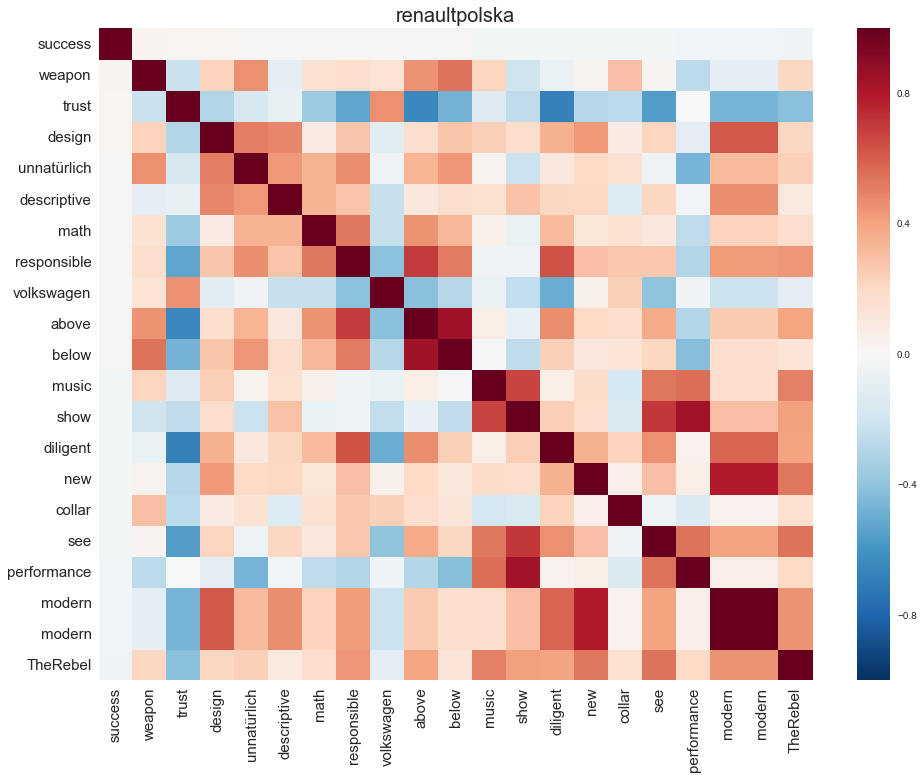

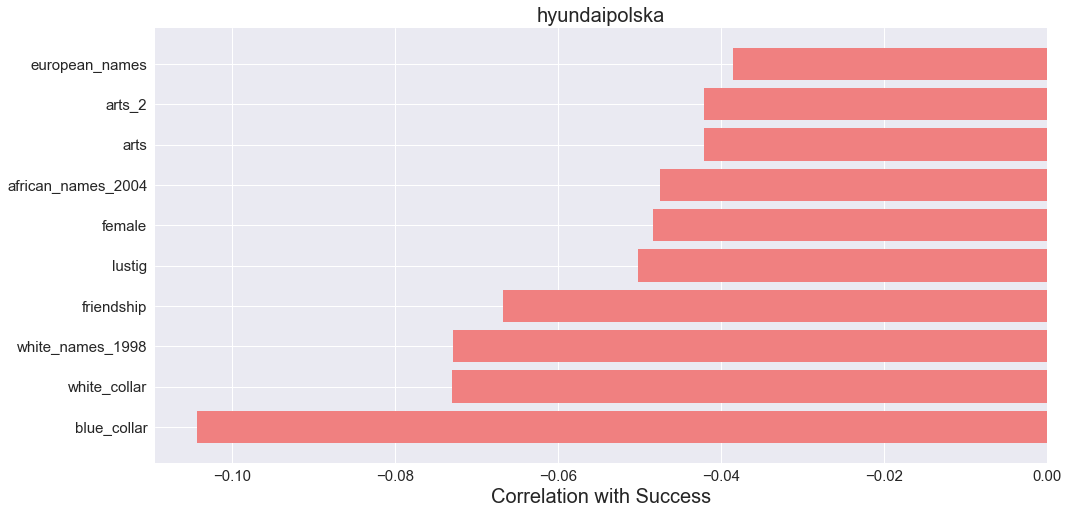

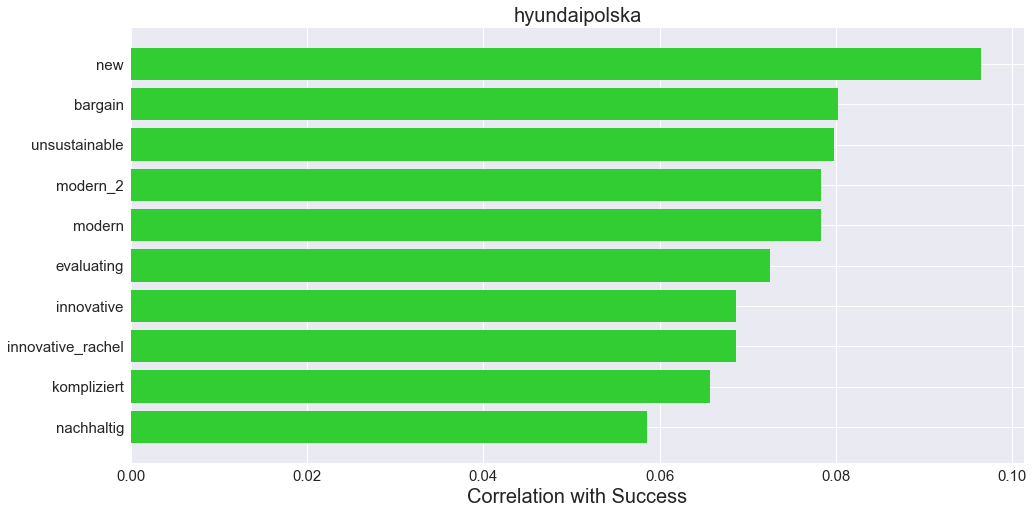

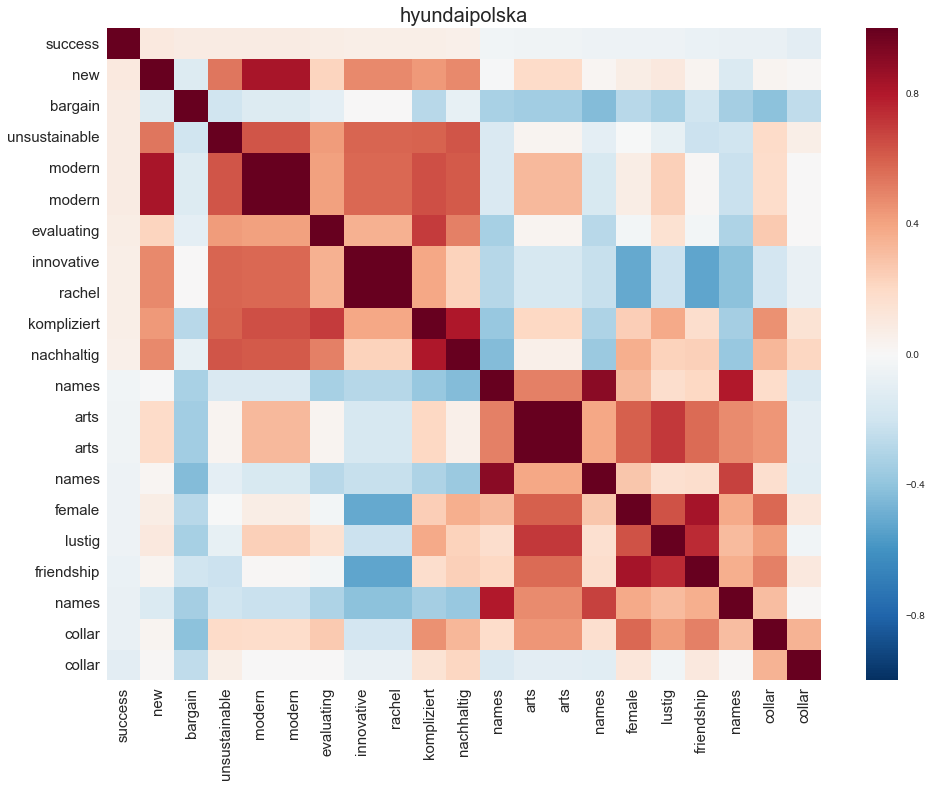

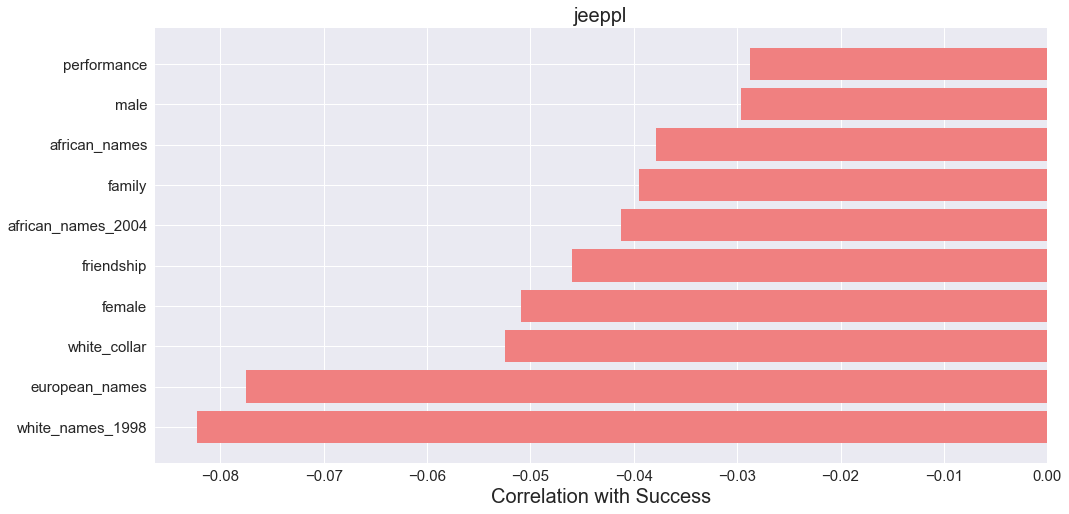

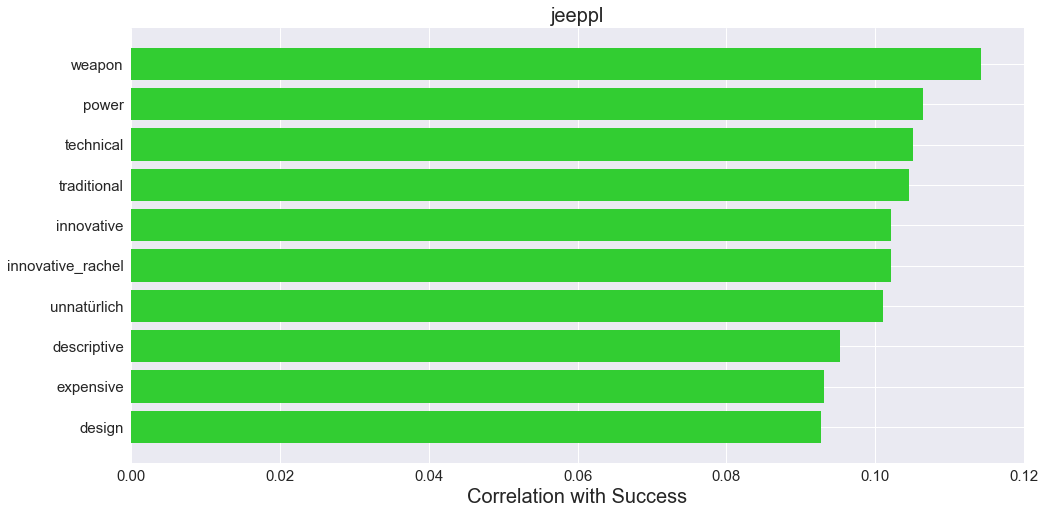

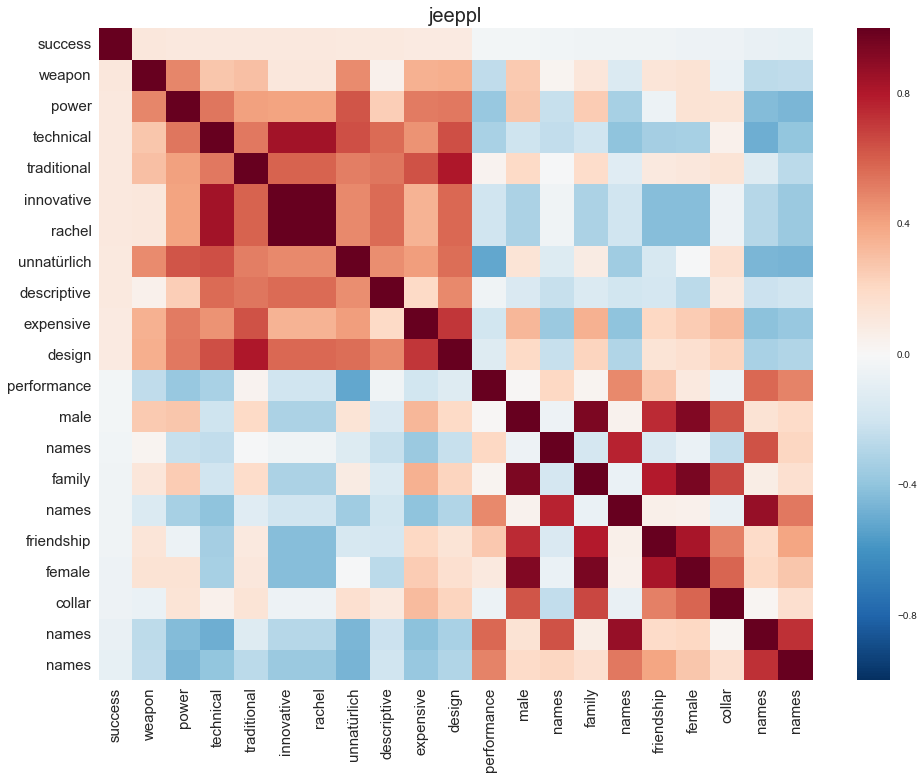

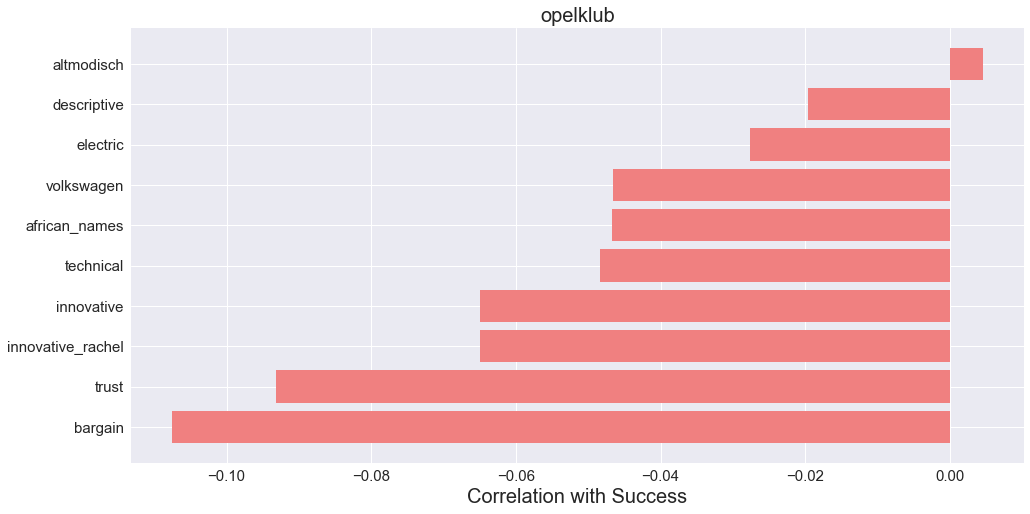

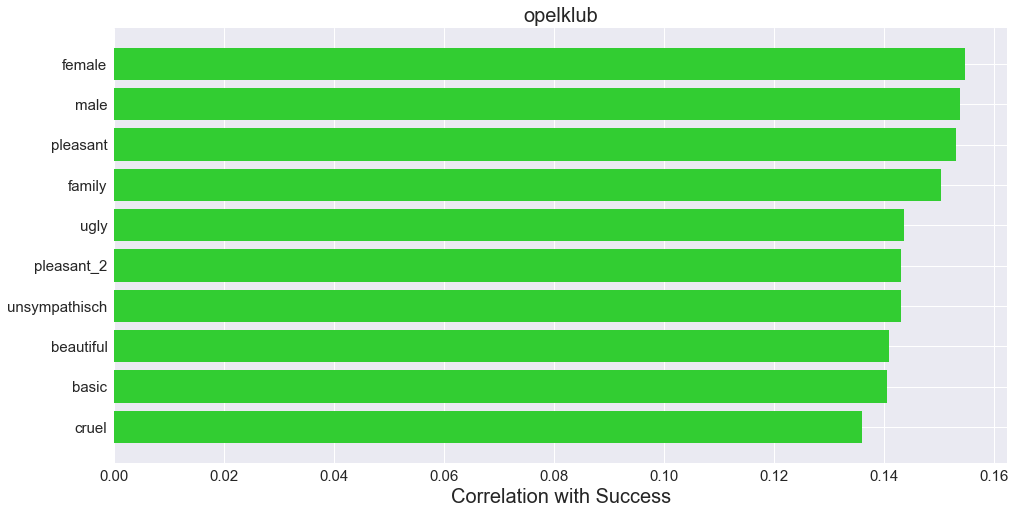

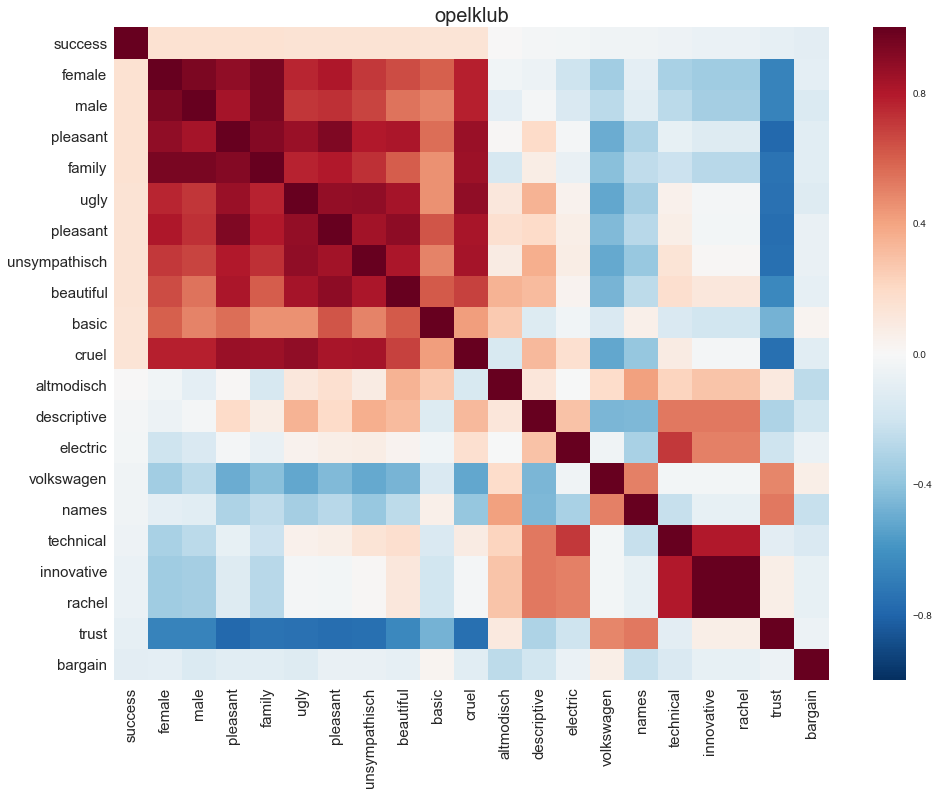

In [18]:
for file, filename in zip(files, filenames):
    try:
        print("doing {}".format(filename))
        pl = preprocess_csv(file)
        feats = get_similarity_features(pl, emb, dimensions, filename)        
        get_top_bot(feats, filename)
    except:
        print("error encountered in {}".format(filename))
        continue

In [ ]:
for file, filename in zip(files, filenames):
    try:
        print("doing {}".format(filename))
        pl = preprocess_csv(file)
        feats = get_similarity_features(pl, emb, dimensions, filename, 0.3)        
        get_top_bot(feats, filename, '30')
    except:
        print("error encountered in {}".format(filename))
        continue

# Inter-Brand Comparisons

In [38]:
def plot_wordclouds(i, thres):
    data = pd.read_csv(corr_files[i], index_col='Unnamed: 0')
    top = data.columns[2:12]
    bottom = data.columns[12:]
    
    plt.figure(figsize=(15,10))

    top_words = [x.split()[1] for x in data.index[data['success']>thres][1:]] 
    bot_words = [x.split()[1] for x in data.index[data['success']<-thres][1:]]

    plt.subplot(121)
    plt.axis("off");
    if len(top_words) != 0:
        print(' '.join(top_words))
        wordcloud = WordCloud(width=600, height=500, background_color='white', prefer_horizontal=1, relative_scaling=0, min_font_size=70, max_font_size=70, stopwords = []).generate('healthy untrustworthy unwirksam impractical dead above below ugly bad cruel')
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title('Positively Correlated\n{} (>{})\n'.format(corr_filenames[i], str(thres)), size=25, )

    plt.subplot(122)
    plt.axis('off')
    if len(bot_words) != 0:
        wordcloud = WordCloud(width=600, height=500, background_color='white', prefer_horizontal=1, relative_scaling=0, min_font_size=70, max_font_size=70, stopwords = []).generate(' '.join([x.split()[1] for x in data.index[data['success']<-thres][1:]]))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title('Negatively Correlated \n{} (<-{})\n'.format(corr_filenames[i], str(thres)), size=25, )

    plt.savefig('fig/brands/idf/wordclouds_{}.png'.format(corr_filenames[i]), bbox_inches = 'tight')
    plt.clf()

In [39]:
i=10
thres=.1

In [24]:
data = pd.read_csv(corr_files[i], index_col='Unnamed: 0')
top = data.columns[2:12]
bottom = data.columns[12:]

plt.figure(figsize=(15,10))

top_words = [x.split()[1] for x in data.index[data['success']>thres][1:]] 
bot_words = [x.split()[1] for x in data.index[data['success']<-thres][1:]]

top_corr = data.loc[data['success']>thres,'success'][1:].values
bot_corr = -data.loc[data['success']<-thres,'success'][1:].values

# scale correlations to 1:20
top_corr = 19*(top_corr-min(top_corr))/(max(top_corr)-min(top_corr))+1
bot_corr = 19*(bot_corr-min(bot_corr))/(max(bot_corr)-min(bot_corr))+1

top_freqs = dict(zip(top_words, top_corr))
bot_freqs = dict(zip(bot_words, bot_corr))

plt.subplot(121)
plt.axis("off");
if len(top_words) != 0:
    print(' '.join(top_words))
    wordcloud = WordCloud(width=1000, height=600, background_color='white', prefer_horizontal=1, color_func=my_tf_color_func(top_freqs, 'G')).generate_from_frequencies(top_freqs, max_font_size=100)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title('Positively Correlated\n{} (>{})\n'.format(corr_filenames[i], str(thres)), size=25, )

plt.subplot(122)
plt.axis('off')
if len(bot_words) != 0:
    print(' '.join(bot_words))
    wordcloud = WordCloud(width=1000, height=600, background_color='white', prefer_horizontal=1, color_func=my_tf_color_func(bot_freqs, 'R')).generate_from_frequencies(bot_freqs, max_font_size=100)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title('Negatively Correlated \n{} (<-{})\n'.format(corr_filenames[i], str(thres)), size=25, )


IndexError: list index out of range

In [66]:
x = pd.read_csv('data/brands/correlogram_volkswagenpolska.csv')['success']

In [7]:
def my_tf_color_func(dictionary, color):
    maxval = max(dictionary.values())
    minval = min(dictionary.values())
    def my_tf_color_func_inner(word, font_size, position, orientation, random_state=None, **kwargs):
        if len(dictionary) > 1:
            value = (dictionary[word] - minval) / (maxval - minval)
        else:
            value = 1
        if color == 'R':
            return "rgb({}, 0, 0)".format(int(value*255))
        elif color == 'G':
            return "rgb(0, {}, 0)".format(int(value*255))
    return my_tf_color_func_inner


In [8]:
def plot_wordclouds(i, count, thres, top_words, bot_words, top_corr, bot_corr, fig):

    ax1 = fig.add_subplot(19, 2, count)
    ax1.axis("off");
    if len(top_words) != 0:
        # scale correlations to 1:20
        if len(top_words) > 1:
            top_corr = 19*(top_corr-min(top_corr))/(max(top_corr)-min(top_corr))+1
        else:
            top_corr = [20]
        top_freqs = dict(zip(top_words, top_corr))
        
        wordcloud = WordCloud(width=1000, height=600, background_color='white', prefer_horizontal=1, color_func=my_tf_color_func(top_freqs, 'G')).generate_from_frequencies(top_freqs, max_font_size=100)
        ax1.imshow(wordcloud, interpolation='bilinear')
        ax1.set_title('\n{}\nPOS\n'.format(corr_filenames[i], str(thres)), size=42, fontweight='bold')

    ax2 = fig.add_subplot(19, 2, count+1)
    ax2.axis('off')
    if len(bot_words) != 0:
        # scale correlations to 1:20
        if len(bot_words) > 1:
            bot_corr = 19*(bot_corr-min(bot_corr))/(max(bot_corr)-min(bot_corr))+1
        else:
            bot_corr = [20]
        bot_freqs = dict(zip(bot_words, bot_corr))
        
        wordcloud = WordCloud(width=1000, height=600, background_color='white', prefer_horizontal=1, color_func=my_tf_color_func(bot_freqs, 'R')).generate_from_frequencies(bot_freqs, max_font_size=100)
        ax2.imshow(wordcloud, interpolation='bilinear')
        ax2.set_title('\n{}\nNEG\n'.format(corr_filenames[i], str(thres)), size=42, fontweight='bold')

#     plt.savefig('fig/brands/wordclouds_{}.png'.format(corr_filenames[i]), bbox_inches = 'tight')

In [60]:
data.index[data['success']>0.1][1:]

Index(['names', 'altmodisch', 'trust', 'volkswagen'], dtype='object')

In [40]:
corr_files = ['data/brands/idf/' + x for x in os.listdir('data/brands/idf') if x.endswith('.csv') and x.startswith('unlabel')]
corr_filenames = [x[x.find('/')+38: x.find('.csv')] for x in corr_files]

In [41]:
corr_filenames

['volkswagenpolska',
 'lexuspolska',
 'jaguarpolska',
 'toyotapolska',
 'mercedesbenzpolska',
 'hondapolska',
 'fiatpl',
 'chevroletpl',
 'skodapolska',
 'ford.polska',
 'opelklub',
 'porschepl',
 'renaultpolska',
 'jeeppl',
 'hyundaipolska',
 'seatpolska',
 'bmw.polska',
 'citroenpolska',
 'landroverpolska',
 'ferrarikatowice',
 'peugeotpolska',
 'audipl',
 'kiamotorspolska']

volkswagenpolska
lexuspolska
jaguarpolska
toyotapolska
mercedesbenzpolska
hondapolska
fiatpl
chevroletpl
skodapolska
ford.polska
opelklub
porschepl
renaultpolska
jeeppl
hyundaipolska
seatpolska
bmw.polska
citroenpolska
landroverpolska
ferrarikatowice
peugeotpolska
audipl
kiamotorspolska


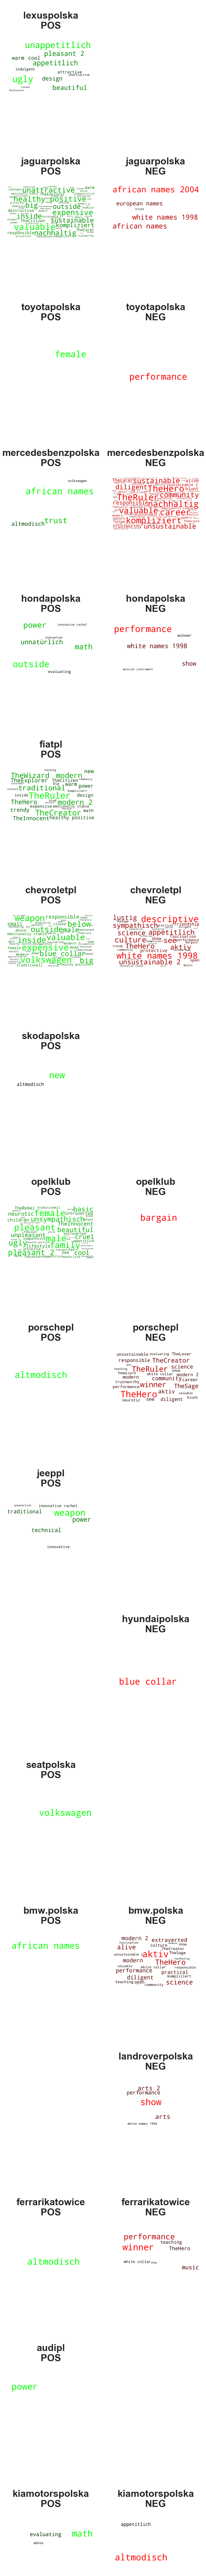

In [42]:
fig = plt.figure(figsize=(15,220))

thres = .1
count = 1
for i in range(len(corr_filenames)):
    print(corr_filenames[i])
    data = pd.read_csv(corr_files[i], index_col='Unnamed: 0')

    to_retain = [x for x in data.columns if 'dim' in x or x=='success']
    data = data.loc[to_retain, to_retain]

    data.index = [(re.sub(r'_+', ' ', get_label(x))) for x in data.index]
    data.columns = [(re.sub(r'_+', ' ', get_label(x))) for x in data.columns]

    top_words = list(data.index[data['success']>thres][1:])
    top_words = [x for x in top_words if x != 'innovative_rachel']

    bot_words = list(data.index[data['success']<-thres])
    bot_words = [x for x in bot_words if x != 'innovative_rachel']

    if (len(top_words) != 0) or (len(bot_words) != 0):
        top_corr = data.loc[data['success']>thres,'success'][1:].values
        bot_corr = -data.loc[data['success']<-thres,'success'].values
        plot_wordclouds(i, count, .1, top_words, bot_words, top_corr, bot_corr, fig)
        count += 2
    plt.savefig('fig/brands/idf/wordclouds_ALL_idf.png', bbox_inches = 'tight')
